In [1]:
import numpy as np
import pandas as pd 
import re
import copy

from datetime import datetime as dt
from datetime import timedelta
from datetime import time
from pytz import timezone

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# 1. JEPXデータの整形
### JEPXデータの読み込み

In [2]:
# csvデータ読み込み
# ヘッダーに日本語が混じってる ⇒ encoding="SHIFT-JIS"
SPOT = pd.read_csv("spot.csv", encoding="SHIFT-JIS")

### 不要データの削除

In [3]:
# 年月日情報と九州のエリアプライス以外は不要 ⇒ 必要な情報だけのデータフレーム"SPOT"を定義
ObjctVariable = ['YMD','Tcode','エリアプライス九州(円/kWh)']
SPOT = SPOT[ObjctVariable]

In [4]:
SPOT = SPOT.rename(columns={"エリアプライス九州(円/kWh)":"Kyusyu_Price"})

### "曜日"列の追加

In [5]:
# "年月日"列を年月日として認識し、weekday()メソッドを実行して、曜日で返す
def day_of_the_week(x):
    date = dt.strptime(x, "%Y/%m/%d")
    return date.weekday()

In [6]:
# "年月日"列から年月日を読み込んで、対応する曜日を"曜日"列に入力
SPOT["Weekday"] = SPOT["YMD"].apply(day_of_the_week)

### 内閣府HPより祝日・休日情報.csvの読み込み

In [7]:
# csvデータ読み込み
# 日本語が混じってる ⇒ encoding="SHIFT-JIS"
syukujitsu_kyujitsu = pd.read_csv("syukujitsu_kyujitsu.csv", encoding="SHIFT-JIS")

### 祝日・休日コード＝7 をSPOTデータフレームの該当日の"曜日"列書き換え

In [8]:
# "syukujitsu_kyujitsu"の"国民の祝日・休日月日"列を yyyy-mm-dd から yyyy/mm/dd 形式に変更（SPOT"年月日"列の形式に合わせた） 
syukujitsu_kyujitsu["国民の祝日・休日月日"] = syukujitsu_kyujitsu["国民の祝日・休日月日"].replace(r"-", "/",regex = True)

# "国民の祝日・休日月日"列をnumpy配列(つまりベクトル)にしたものを"dayoffs"と定義
dayoffs = syukujitsu_kyujitsu["国民の祝日・休日月日"].values

# SPOTの"年月日"列に、dayoffsベクトルの中身(祝日・休日)と一致した日があれば、その行の"曜日"列を7に書き換え
for i in dayoffs:
    SPOT.loc[SPOT["YMD"] == i, "Weekday"] = 7

### "曜日"列が 0～4 = ON、5～7 = OFF とする"OnOff"列を追加

In [9]:
SPOT["OnOff"] = "ON"
SPOT["OnOff"][ SPOT["Weekday"] > 4 ] = "OFF"

/Users/calmtree443/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### "年月日"列にHH:MMの情報も加えて"年月日時分"列に変更

In [10]:
# "年月日"列をTimeStamp型にしてtimedeltaオプション経由でHHMMを足す
def ymdhm_seriesmake(x):
    ymdhm = dt.strptime(x["YMD"], "%Y/%m/%d") + timedelta(minutes=(x["Tcode"] - 1) * 30)
    ymdhm = timezone("Asia/Tokyo").localize(ymdhm)# JSTとして認識させる
    return ymdhm

In [11]:
# 年月日にHHMMが加わった"年月日時分"列を新たに追加
SPOT["YMDHM"] = SPOT.apply(ymdhm_seriesmake,axis=1)

# "年月日時分"が入った代わりに"年月日"列を落とす
SPOT = SPOT.drop("YMD", axis=1)

In [12]:
SPOT.tail()

Tcode  Kyusyu_Price  Weekday OnOff                     YMDHM
9259     44          9.24        6   OFF 2018-06-17 21:30:00+09:00
9260     45          9.09        6   OFF 2018-06-17 22:00:00+09:00
9261     46          8.74        6   OFF 2018-06-17 22:30:00+09:00
9262     47          7.81        6   OFF 2018-06-17 23:00:00+09:00
9263     48          7.41        6   OFF 2018-06-17 23:30:00+09:00

# 2. GPVデータの整形

In [13]:
####################
### 【DateTime】 ### "DateTime"列の毎正時の間に**:30コマを埋め込み30分ピッチのデータフレームを作る
####################

# csvデータ読み込み
gpv = pd.read_csv("panoco/fukuoka.csv")

# "DateTime"列を年月日時分として認識させ、Series型の"datetime00"に格納
def datetime00_seriesmake(x):
    datetime00 = dt.strptime(x, "%Y/%m/%d %H:%M:%S")
    datetime00 = timezone("UTC").localize(datetime00)# UTCとして認識させる
    return datetime00
datetime00 = gpv["DateTime"].apply(datetime00_seriesmake)

# 毎正時に30分を加算して**:30コマを作る
datetime30 = datetime00 + timedelta(minutes=30)

# # datetime00(**:00コマ)とdatetime30(**:30コマ)を結合して時系列にソート
DateTime48 = datetime00.append(datetime30).sort_values()

# # 時系列の48コマをDataFrame型にして"GPVdf"と定義
GPVdf = pd.DataFrame(DateTime48, columns=["DateTime"]).reset_index(drop=True)

# # 12:30zの行(最尾行)は不要なので削除、削除後のデータフレームを"GPVdf"と再定義
GPVdf = GPVdf.drop(GPVdf.shape[0]-1)

##########################################################################################

GPV_points = ["fukuoka", "saga", "nagasaki", "kumamoto", "oita", "miyazaki", "kagoshima"]

for prf in GPV_points:
    gpv = pd.read_csv("panoco/" + prf + ".csv")

###########################
### 【DSWRF（日射量）】 ### 内挿データを作って30分前へスライドしながら30分ピッチのデータフレームに埋め込む
###########################

# 内挿処理した日射量データを毎正時に埋め込んだデータを格納するリストを"DSWRF48"と定義
    DSWRF48 = []

# ORGの"DSWRF_SFC"列をarray型にして"dswrf00"と定義
    dswrf00 = gpv["DSWRF_SFC"].values

# **:30の値を"dswrf30"と定義して内挿処理したものをDSWRF48へ時系列に整列させながら放り込む
    for i in range(len(dswrf00)-1):
        dswrf30 = (dswrf00[i] + dswrf00[i+1]) / 2
        DSWRF48.append(dswrf00[i])
        DSWRF48.append(round(dswrf30,2))
    DSWRF48.append(dswrf00[-1])
    
# リスト"dswrf48"の先頭は不要なので落とす →30分前にスライド
    del DSWRF48[0]

# リスト"dswr48"の後尾に0を追加して他の気象要素のデータ数を合わせる
    DSWRF48.append(0)

# "GPVdf"に"DSWRF"を連結したデータフレームを"GPVdf"と再定義
    GPVdf["DSWRF_" + prf] = DSWRF48


#######################
### 【TMP（気温）】 ### 内挿データを作って30分ピッチのデータフレームに埋め込む
#######################

# 内挿処理した気温データを毎正時に埋め込んだデータを格納するリストを"TMP48"と定義
    TMP48 = []

# ORGの"TMP_SFC"列をarray型にして"tmp00"と定義
    tmp00 = gpv["TMP_SFC"].values
    
# **:30の値を"tmp30"と定義して内挿処理したものをTMP48へ時系列に整列させながら放り込む
    for i in range(len(tmp00)-1):
        tmp30 = (tmp00[i] + tmp00[i+1]) / 2
        TMP48.append(tmp00[i])
        TMP48.append(round(tmp30,2))
    TMP48.append(tmp00[-1])
    
# "GPVdf"に"TMP"と"TMPdiff"を連結したデータフレームを"GPVdf"と再定義
# "TMPdiff" → 20℃を基準に"TMP"との差分をとったデータ
    GPVdf["TMP_" + prf] = TMP48
    GPVdf["TMPdiff_" + prf] = abs(GPVdf["TMP_" + prf] - 20)

    
##########################
### 【APCP（降水量）】 ### 前1時間降水量を30分値にして前へスライドしながら30分ピッチのデータフレームに埋め込む
##########################

# 30分値にした降水量データを格納するリストを"APCP48"と定義
    APCP48 = []

# ORGの"APCP_SFC"列をarray型にして"apcp00"と定義
    apcp00 = gpv["APCP_SFC"].values
    
# 前1時間降水量/2で30分値にしたものを前2コマへ振り分けてAPCP48へ放り込む
    for i in range(1,len(apcp00)):
        APCP48.append(round(apcp00[i] / 2,2))
        APCP48.append(round(apcp00[i] / 2,2))

# リスト最尾に放り込むべき降水量が無いので、apcp00の最尾の降水量/2をもう一度使う
    APCP48.append(round(apcp00[-1] / 2,2))
    
# 30分ピッチの降水量データ列をDataFrame型にして"APCP"と定義
    GPVdf["APCP_" + prf] = APCP48

    
##########################
### 【RH（相対湿度）】 ### 内挿データを作って30分ピッチのデータフレームに埋め込む
##########################

# 内挿処理した気温データを毎正時に埋め込んだデータを格納するリストを"RH48"と定義
    RH48 = []

# ORGの"RH_SFC"列をarray型にして"rh00"と定義
    rh00 = gpv["RH_SFC"].values

# **:30の値を"rh30"と定義して内挿処理したものをRH48へ時系列に整列させながら放り込む
    for i in range(len(rh00)-1):
        rh30 = (rh00[i] + rh00[i+1]) / 2
        RH48.append(rh00[i])
        RH48.append(round(rh30,2))
    RH48.append(rh00[-1])
    
# 30分ピッチの相対湿度データ列をDataFrame型にして"RH"と定義
    GPVdf["RH_" + prf] = RH48
    
##########################################################################################    

# 12:30zの行を削除
GPVdf = GPVdf.drop(GPVdf.index[ GPVdf["DateTime"].apply(lambda x: x.time()) == time(12,30) ])

In [14]:
GPVdf.head()

DateTime  DSWRF_fukuoka  TMP_fukuoka  TMPdiff_fukuoka  \
0 2017-12-06 15:00:00+00:00            0.0         6.81            13.19   
1 2017-12-06 15:30:00+00:00            0.0         6.73            13.27   
2 2017-12-06 16:00:00+00:00            0.0         6.65            13.35   
3 2017-12-06 16:30:00+00:00            0.0         6.64            13.36   
4 2017-12-06 17:00:00+00:00            0.0         6.63            13.37   

   APCP_fukuoka  RH_fukuoka  DSWRF_saga  TMP_saga  TMPdiff_saga  APCP_saga  \
0           0.0       62.32         0.0      3.60         16.40        0.0   
1           0.0       62.34         0.0      3.42         16.58        0.0   
2           0.0       62.37         0.0      3.25         16.75        0.0   
3           0.0       61.86         0.0      3.16         16.84        0.0   
4           0.0       61.36         0.0      3.07         16.93        0.0   

       ...       DSWRF_miyazaki  TMP_miyazaki  TMPdiff_miyazaki  \
0      ...                  0.0          3.33             16.67   
1      ...                  0.0          3.11             16.89   
2      ...                  0.0          2.89             17.11   
3      ...                  0.0          2.79             17.21   
4      ...                  0.0          2.69             17.31   

   APCP_miyazaki  RH_miyazaki  DSWRF_kagoshima  TMP_kagoshima  \
0            0.0        60.34              0.0           7.65   
1            0.0        60.46              0.0           7.54   
2            0.0        60.59              0.0           7.43   
3            0.0        60.22              0.0           7.34   
4            0.0        59.86              0.0           7.25   

   TMPdiff_kagoshima  APCP_kagoshima  RH_kagoshima  
0              12.35             0.0         62.99  
1              12.46             0.0         63.56  
2              12.57             0.0         64.12  
3              12.66             0.0         64.03  
4              12.75             0.0         63.94  

[5 rows x 36 columns]

# 3. 分析

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet

/Users/calmtree443/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/calmtree443/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### JEPXデータとGPVデータを連結

In [16]:
JEPXdf_ORG = pd.merge(SPOT, GPVdf, left_on='YMDHM', right_on='DateTime')

### OnOffをダミー変数にする

In [17]:
JEPXdf_ORG = pd.get_dummies(data=JEPXdf_ORG, columns=["OnOff"])

In [18]:
JEPXdf_ORG.head()

Tcode  Kyusyu_Price  Weekday                      YMDHM  \
0      1          9.77        3  2017-12-07 00:00:00+09:00   
1      2          9.52        3  2017-12-07 00:30:00+09:00   
2      3          9.52        3  2017-12-07 01:00:00+09:00   
3      4          9.27        3  2017-12-07 01:30:00+09:00   
4      5          9.36        3  2017-12-07 02:00:00+09:00   

                   DateTime  DSWRF_fukuoka  TMP_fukuoka  TMPdiff_fukuoka  \
0 2017-12-06 15:00:00+00:00            0.0         6.81            13.19   
1 2017-12-06 15:30:00+00:00            0.0         6.73            13.27   
2 2017-12-06 16:00:00+00:00            0.0         6.65            13.35   
3 2017-12-06 16:30:00+00:00            0.0         6.64            13.36   
4 2017-12-06 17:00:00+00:00            0.0         6.63            13.37   

   APCP_fukuoka  RH_fukuoka    ...     TMPdiff_miyazaki  APCP_miyazaki  \
0           0.0       62.32    ...                16.67            0.0   
1           0.0       62.34    ...                16.89            0.0   
2           0.0       62.37    ...                17.11            0.0   
3           0.0       61.86    ...                17.21            0.0   
4           0.0       61.36    ...                17.31            0.0   

   RH_miyazaki  DSWRF_kagoshima  TMP_kagoshima  TMPdiff_kagoshima  \
0        60.34              0.0           7.65              12.35   
1        60.46              0.0           7.54              12.46   
2        60.59              0.0           7.43              12.57   
3        60.22              0.0           7.34              12.66   
4        59.86              0.0           7.25              12.75   

   APCP_kagoshima  RH_kagoshima  OnOff_OFF  OnOff_ON  
0             0.0         62.99          0         1  
1             0.0         63.56          0         1  
2             0.0         64.12          0         1  
3             0.0         64.03          0         1  
4             0.0         63.94          0         1  

[5 rows x 42 columns]

### 移動平均予測値を特徴量に追加

In [19]:
MovingAvg_FCT = pd.read_csv("MovingAvg_allFCT.csv", index_col=0)
m_ave = MovingAvg_FCT.values
JEPXdf_ORG["Moving_Ave_Price"] = m_ave.reshape( m_ave.shape[0] * m_ave.shape[1] )

### 学習条件設定

In [20]:
############################################################
### ウィンドウ期間(学習対象期間)を指定 → 直近過去？ケ月 ###
############################################################
trainMONTHs = 3

# 学習対象日数を"trainDays"とする
trainDAYs = 30 * trainMONTHs

# 時刻コードと時刻コマの対照辞書
TcomaTcode21 = {"0":1, "0.5":2, "1":3, "1.5":4, "2":5, "2.5":6, "3":7, "3.5":8, "4":9, "4.5":10, "5":11, "5.5":12, "6":13, "6.5":14, "7":15, "7.5":16, "8":17, "8.5":18, "9":19, "9.5":20, "10":21, "10.5":22, "11":23, "11.5":24, "12":25, "12.5":26, "13":27, "13.5":28, "14":29, "14.5":30, "15":31, "15.5":32, "16":33, "16.5":34, "17":35, "17.5":36, "18":37, "18.5":38, "19":39, "19.5":40, "20":41, "20.5":42, "21":43}
# TcomaTcode = {"0":1, "0.5":2, "1":3, "1.5":4, "2":5, "2.5":6, "3":7, "3.5":8, "4":9, "4.5":10, "5":11, "5.5":12, "6":13, "6.5":14, "7":15, "7.5":16, "8":17, "8.5":18, "9":19, "9.5":20, "10":21, "10.5":22, "11":23, "11.5":24, "12":25, "12.5":26, "13":27, "13.5":28, "14":29, "14.5":30, "15":31, "15.5":32, "16":33, "16.5":34, "17":35, "17.5":36, "18":37, "18.5":38, "19":39, "19.5":40, "20":41, "20.5":42, "21":43, "21.5":44, "22":45, "22.5":46, "23":47, "23.5":48}

# 実績プライスの1次元配列を"targetprice"を、行数:予測対象日数(学習日数によって変化するので-1)、列数:時刻コマ数(=43)の2次元配列にする
targetprice = np.array(JEPXdf_ORG["Kyusyu_Price"])
targetprice = np.reshape(targetprice, (-1, len(TcomaTcode21)))

### 【線形回帰モデル】

In [24]:
# 予測値を格納するリストを"FCT"と定義
FCT = np.array([])

########################################
### 予測ターゲット列と特徴量列を指定 ###
########################################
target_col = "Kyusyu_Price"
exclude_cols = ["Tcode", "Kyusyu_Price", "Weekday", "YMDHM", "DateTime", \
                "TMP_fukuoka", "TMP_saga", "TMP_nagasaki", "TMP_kumamoto", "TMP_oita", "TMP_miyazaki", "TMP_kagoshima"]
feature_cols = [col for col in JEPXdf_ORG.columns if col not in exclude_cols]

################################
### 予測対象時刻コマのループ ###
################################
for Tcoma in TcomaTcode21:
    Tcode = TcomaTcode21[Tcoma]    
    
# 時刻コードでソートしたデータフレームを"JEPX_T"と定義してインデックスをリセット
    JEPXdf_T = JEPXdf_ORG[JEPXdf_ORG["Tcode"] == Tcode].reset_index(drop=True)

##############################
### ローリング学習のループ ###
##############################
# 学習データ(上からtrainDAYs行) + 教師データ(最尾1行) のデータフレームを"JEPXdf_FCT"と定義
    for i in range(len(JEPXdf_T)-trainDAYs):
        JEPXdf_FCT = JEPXdf_T[i:trainDAYs+1+i].reset_index(drop=True)

##############################
### データフレームの正規化 ###
#############################        
# 近隣県の気象要素は多重共線性がある可能性大 → 次元圧縮するため正規化する列をリストにして""と定義
        NormalizationList = ["DSWRF_fukuoka", "TMPdiff_fukuoka", "APCP_fukuoka", "RH_fukuoka", \
                             "DSWRF_saga", "TMPdiff_saga", "APCP_saga", "RH_saga", \
                             "DSWRF_nagasaki", "TMPdiff_nagasaki", "APCP_nagasaki", "RH_nagasaki", \
                             "DSWRF_kumamoto", "TMPdiff_kumamoto", "APCP_kumamoto", "RH_kumamoto", \
                             "DSWRF_oita", "TMPdiff_oita", "APCP_oita", "RH_oita", \
                             "DSWRF_miyazaki", "TMPdiff_miyazaki", "APCP_miyazaki", "RH_miyazaki", \
                             "DSWRF_kagoshima", "TMPdiff_kagoshima", "APCP_kagoshima", "RH_kagoshima", \
                             "OnOff_OFF", "OnOff_ON", "Moving_Ave_Price"]
# "JEPXdf_FCT"の各列を正規化して"JEPXdf_FCT"と再定義
        sc = StandardScaler()
        JEPXdf_FCT[NormalizationList] = sc.fit_transform(JEPXdf_FCT[NormalizationList])

        
# 機械学習アルゴリズムに投入するためNumPy配列にする
        y_train = np.array(JEPXdf_FCT[target_col][0:trainDAYs])
        X_train = np.array(JEPXdf_FCT[feature_cols][0:trainDAYs])
        y_test = np.array(JEPXdf_FCT[target_col][trainDAYs:])
        X_test = np.array(JEPXdf_FCT[feature_cols][trainDAYs:])  

########################################
### 特徴量データを次元圧縮 → 5次元 ###
########################################
        pca = PCA(n_components = 5)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
##########################    
### 線形回帰モデル投入 ###
##########################
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test)
        FCT = np.r_[FCT, y_pred]

# 1次元配列のFCTを、行数:時刻コマ数(=43)、列数:予測対象日数(学習日数によって変化するので-1)の2次元配列にする
FCT = np.reshape(FCT, (len(TcomaTcode21), -1))

0 回目のループLinerRegression RMSE:  1.8653530286937545


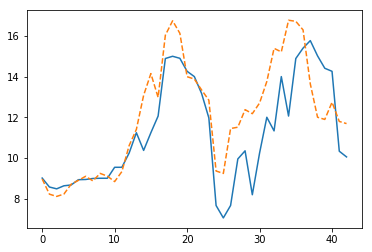

1 回目のループLinerRegression RMSE:  1.5191988865224935


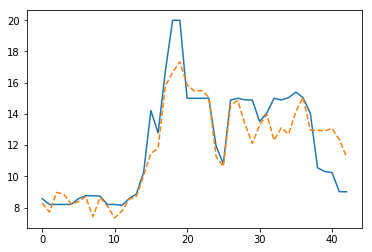

2 回目のループLinerRegression RMSE:  2.860611772971571


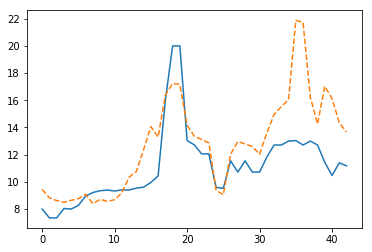

3 回目のループLinerRegression RMSE:  2.197558591530994


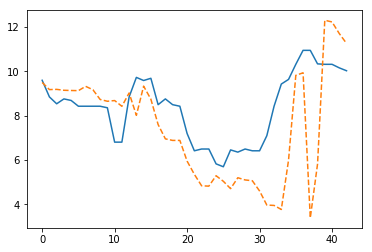

4 回目のループLinerRegression RMSE:  1.860923499273013


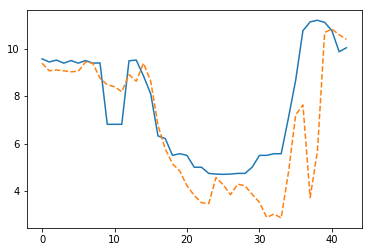

5 回目のループLinerRegression RMSE:  1.5560864307028035


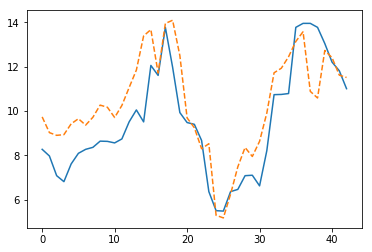

6 回目のループLinerRegression RMSE:  2.0116270154916562


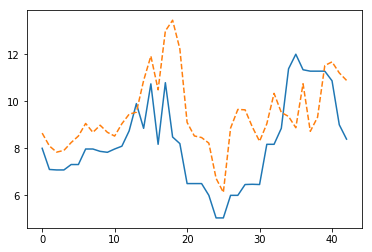

7 回目のループLinerRegression RMSE:  1.363357786732025


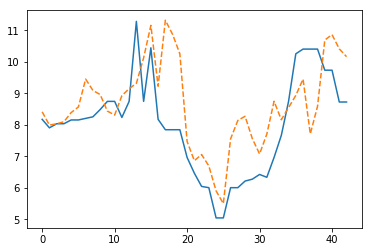

8 回目のループLinerRegression RMSE:  1.904539456891119


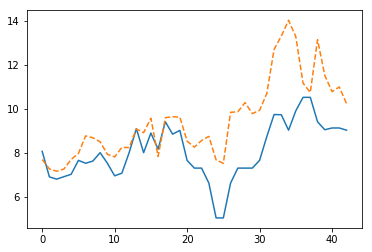

9 回目のループLinerRegression RMSE:  2.8312018972658692


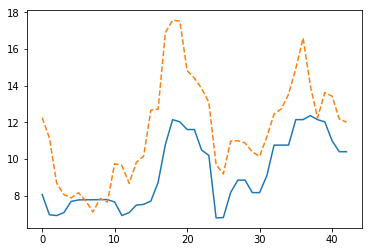

10 回目のループLinerRegression RMSE:  3.5036111197885536


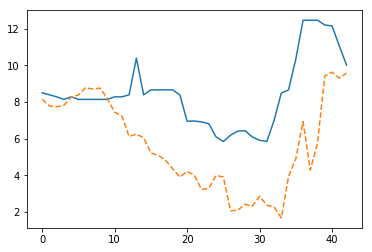

11 回目のループLinerRegression RMSE:  2.199155128567218


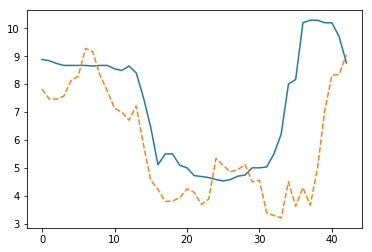

12 回目のループLinerRegression RMSE:  2.4092224682368375


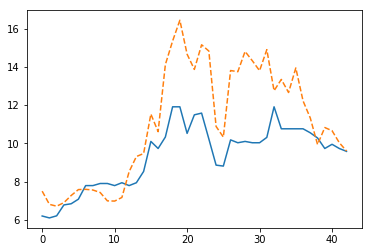

13 回目のループLinerRegression RMSE:  1.7145566132276653


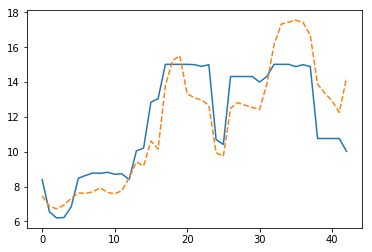

14 回目のループLinerRegression RMSE:  2.945337461787364


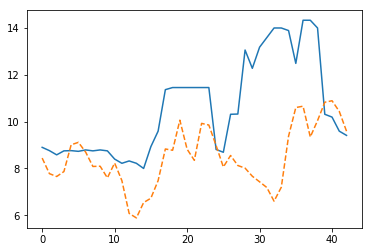

15 回目のループLinerRegression RMSE:  2.3260630753152087


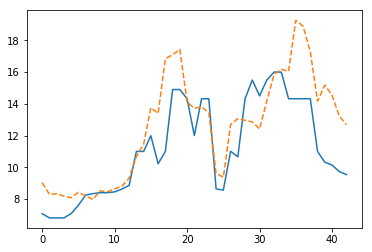

16 回目のループLinerRegression RMSE:  1.4399383607740965


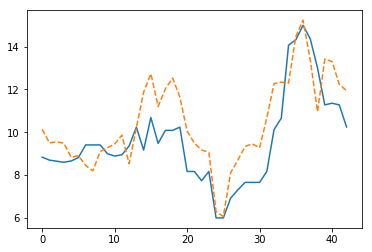

17 回目のループLinerRegression RMSE:  2.5283067693147134


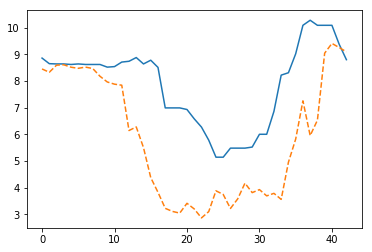

18 回目のループLinerRegression RMSE:  2.093034597903964


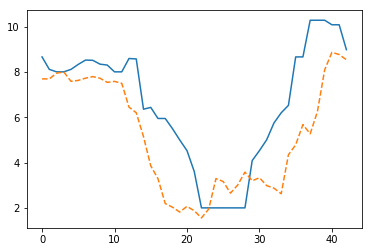

19 回目のループLinerRegression RMSE:  2.0982690725232813


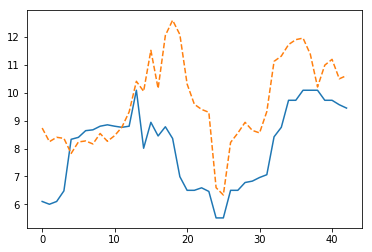

20 回目のループLinerRegression RMSE:  1.1658694313971596


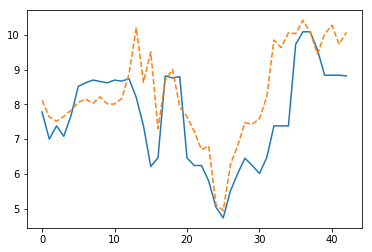

21 回目のループLinerRegression RMSE:  0.9892394509766359


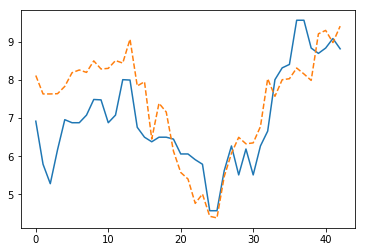

22 回目のループLinerRegression RMSE:  1.294553171120108


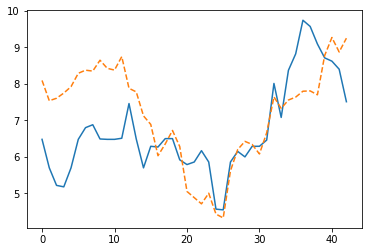

23 回目のループLinerRegression RMSE:  0.7742826126451234


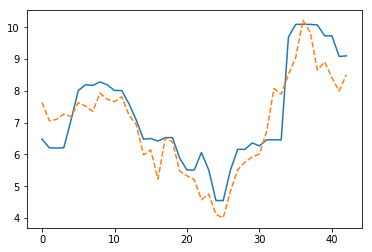

24 回目のループLinerRegression RMSE:  4.101404054232907


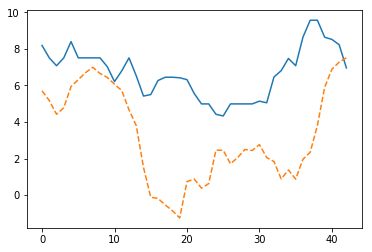

25 回目のループLinerRegression RMSE:  3.1972735121781195


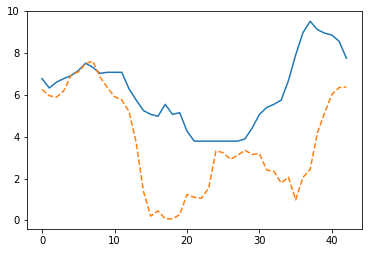

26 回目のループLinerRegression RMSE:  0.944535573826154


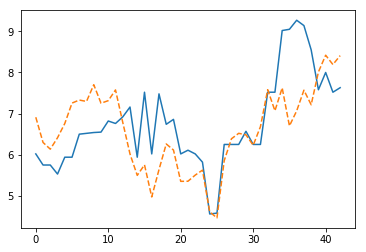

27 回目のループLinerRegression RMSE:  1.3930807861465262


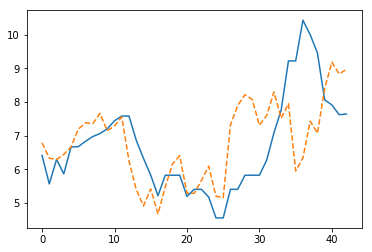

28 回目のループLinerRegression RMSE:  0.9261328612196613


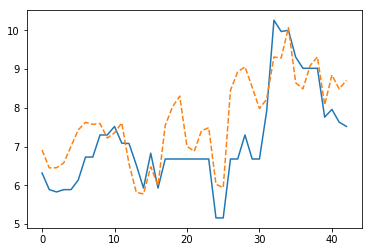

29 回目のループLinerRegression RMSE:  1.6414986804657694


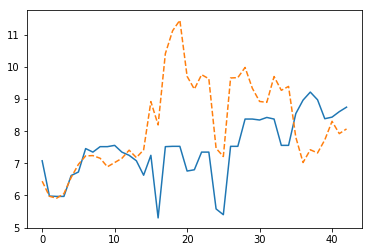

30 回目のループLinerRegression RMSE:  1.972470997532068


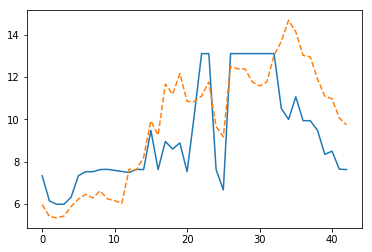

31 回目のループLinerRegression RMSE:  1.538599486204151


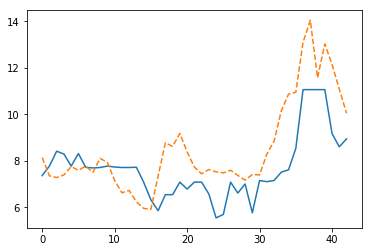

32 回目のループLinerRegression RMSE:  1.2187169326114


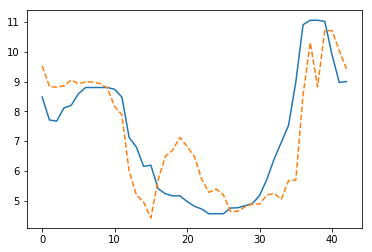

33 回目のループLinerRegression RMSE:  2.536228481408448


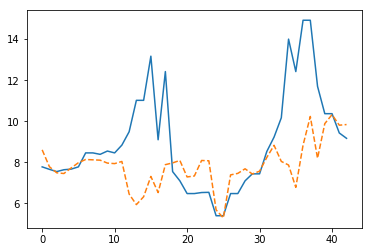

34 回目のループLinerRegression RMSE:  1.992296228844064


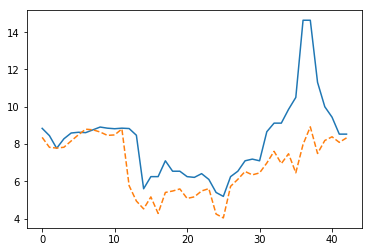

35 回目のループLinerRegression RMSE:  1.6859605136111455


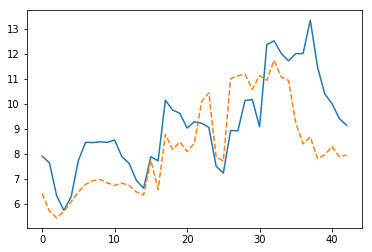

36 回目のループLinerRegression RMSE:  1.0235281231944213


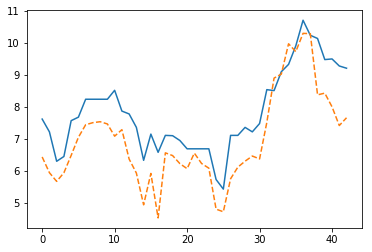

37 回目のループLinerRegression RMSE:  1.4669534307865562


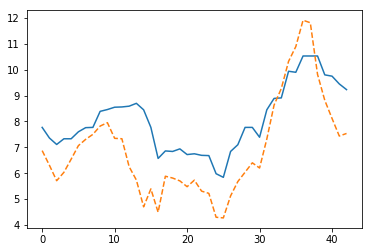

38 回目のループLinerRegression RMSE:  3.5204889290251358


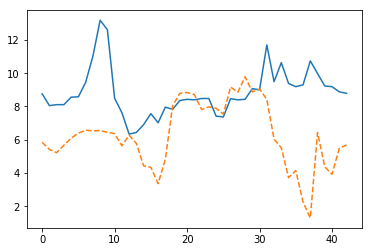

39 回目のループLinerRegression RMSE:  2.135011594530318


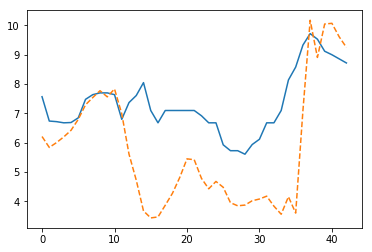

40 回目のループLinerRegression RMSE:  1.3378756138273167


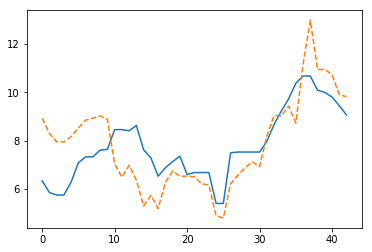

41 回目のループLinerRegression RMSE:  2.1817250480493255


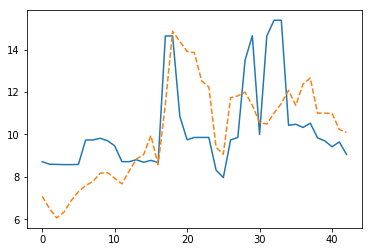

42 回目のループLinerRegression RMSE:  2.0193308741379834


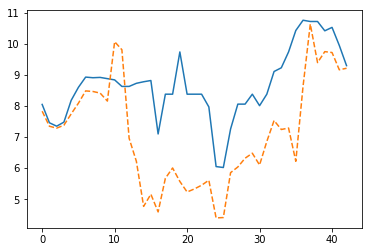

43 回目のループLinerRegression RMSE:  1.3221832819370647


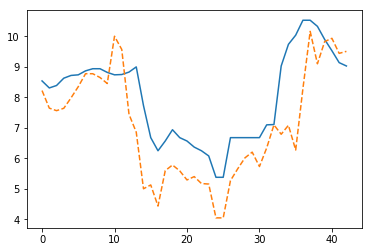

44 回目のループLinerRegression RMSE:  1.5176013356665443


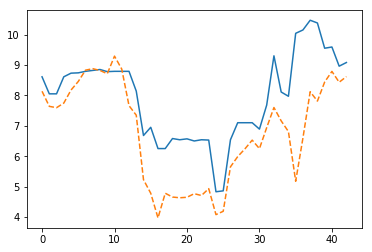

45 回目のループLinerRegression RMSE:  4.264906637228358


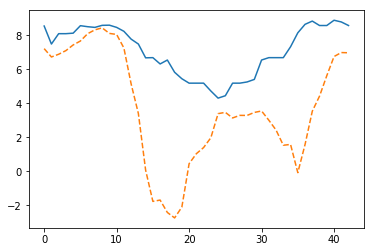

46 回目のループLinerRegression RMSE:  2.938353439551862


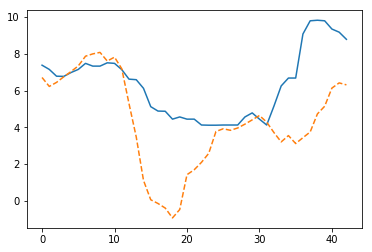

47 回目のループLinerRegression RMSE:  2.2349780808072146


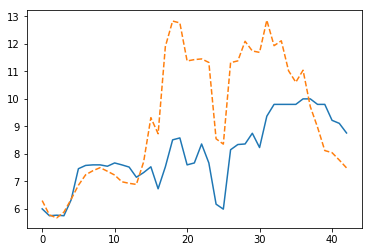

48 回目のループLinerRegression RMSE:  1.6566260702894593


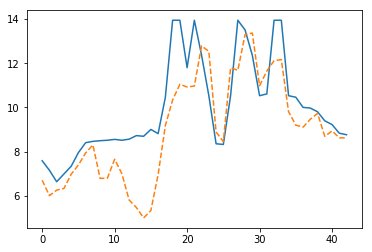

49 回目のループLinerRegression RMSE:  0.9724667066462557


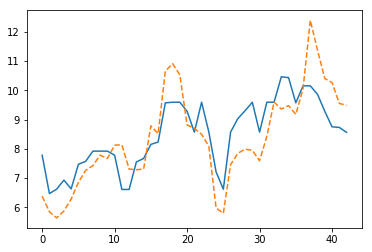

50 回目のループLinerRegression RMSE:  1.0714719050664285


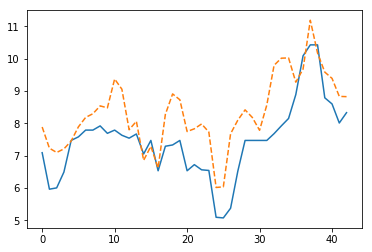

51 回目のループLinerRegression RMSE:  0.9748633812515769


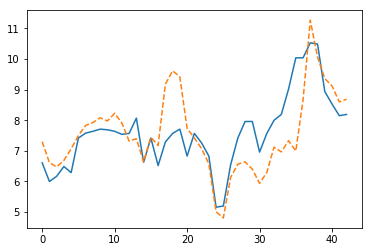

52 回目のループLinerRegression RMSE:  3.583844725301972


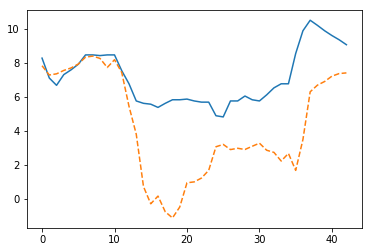

53 回目のループLinerRegression RMSE:  3.1348996786954086


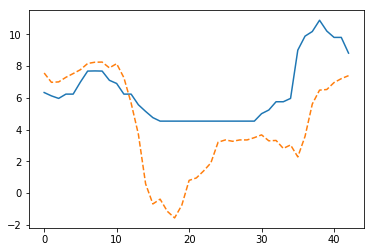

54 回目のループLinerRegression RMSE:  2.1612787354544754


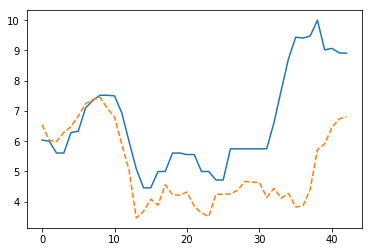

55 回目のループLinerRegression RMSE:  2.0664187705502517


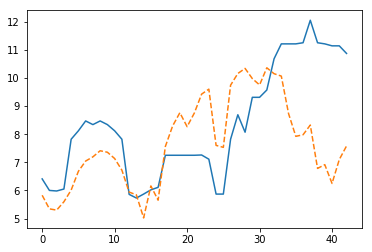

56 回目のループLinerRegression RMSE:  1.9017505625646076


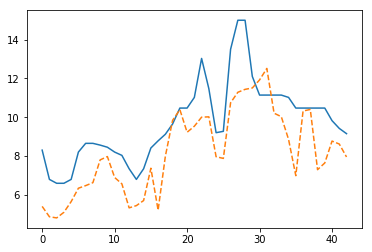

57 回目のループLinerRegression RMSE:  1.968609299538785


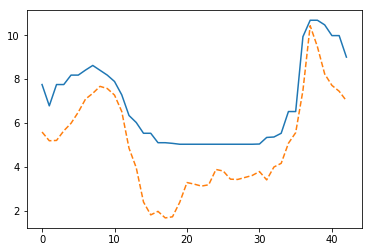

58 回目のループLinerRegression RMSE:  1.9558149992248532


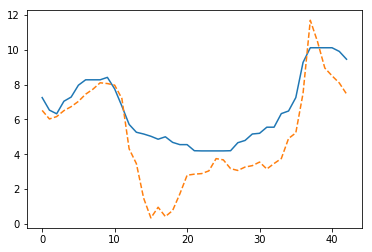

59 回目のループLinerRegression RMSE:  2.5455995245665233


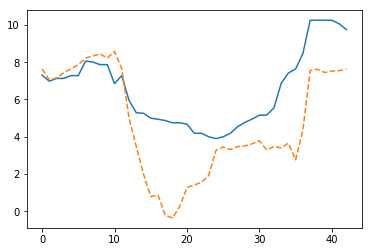

60 回目のループLinerRegression RMSE:  2.0560249665139754


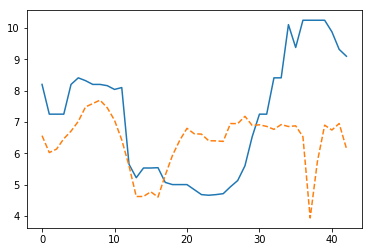

61 回目のループLinerRegression RMSE:  1.640835363769356


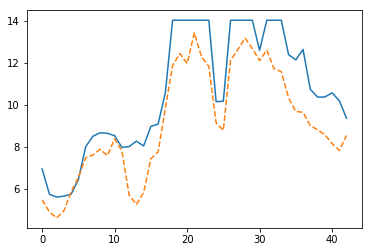

62 回目のループLinerRegression RMSE:  1.4690363231257626


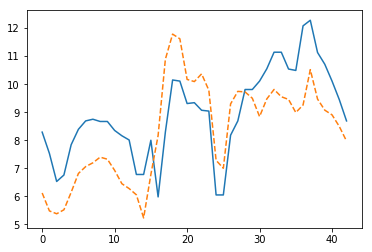

63 回目のループLinerRegression RMSE:  0.8073736039119553


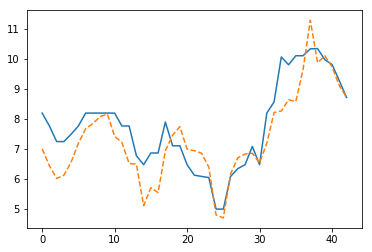

64 回目のループLinerRegression RMSE:  0.6375275791804764


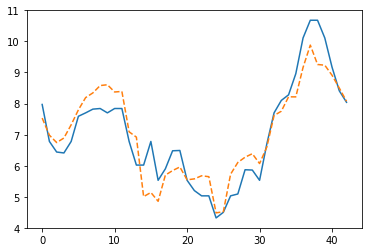

65 回目のループLinerRegression RMSE:  0.7685293379140673


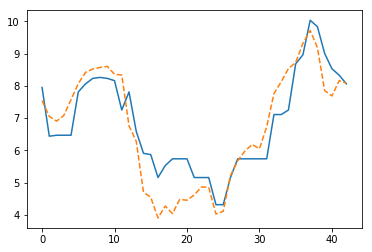

66 回目のループLinerRegression RMSE:  2.2598334073976996


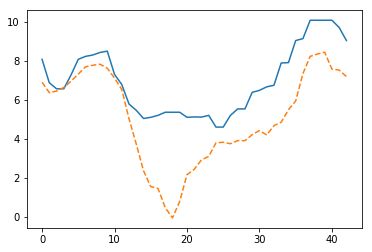

67 回目のループLinerRegression RMSE:  1.435244050058817


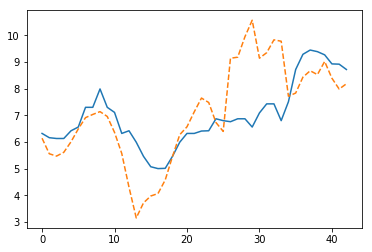

68 回目のループLinerRegression RMSE:  0.9084742030595323


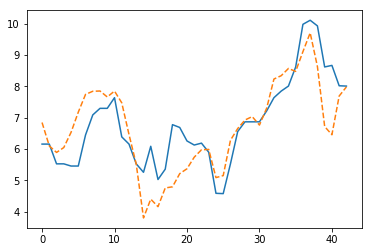

69 回目のループLinerRegression RMSE:  1.0598212711223487


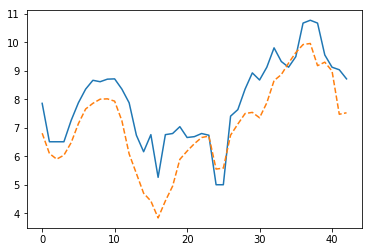

70 回目のループLinerRegression RMSE:  1.0386816893757196


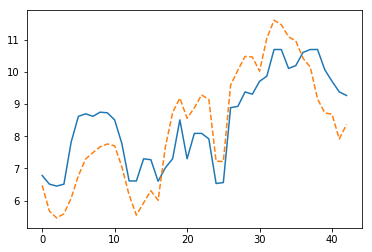

71 回目のループLinerRegression RMSE:  1.2960781033021422


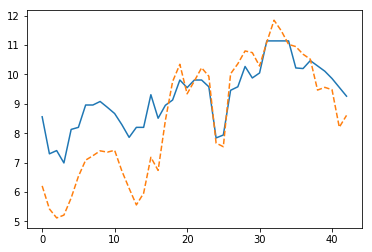

72 回目のループLinerRegression RMSE:  1.0915222415610573


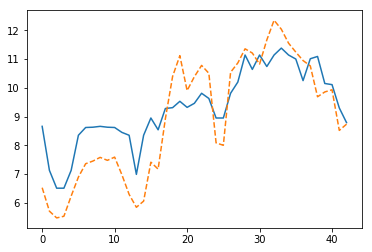

73 回目のループLinerRegression RMSE:  2.050659026816843


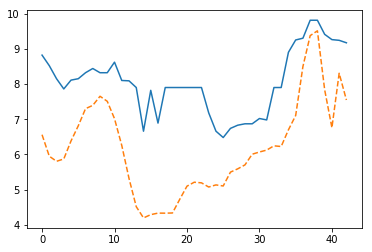

74 回目のループLinerRegression RMSE:  1.0634879740824963


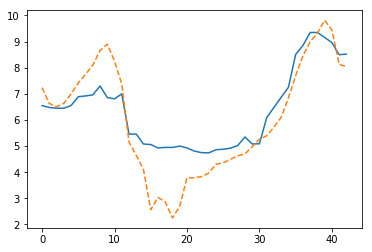

75 回目のループLinerRegression RMSE:  0.7475889601394107


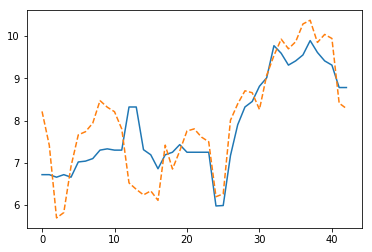

76 回目のループLinerRegression RMSE:  0.5985656204002352


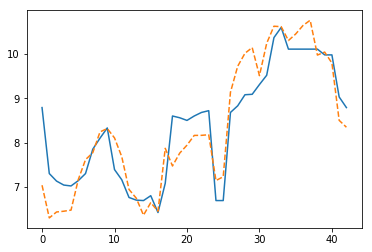

77 回目のループLinerRegression RMSE:  2.2537475958138407


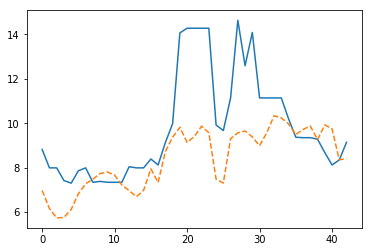

78 回目のループLinerRegression RMSE:  1.4267192817012482


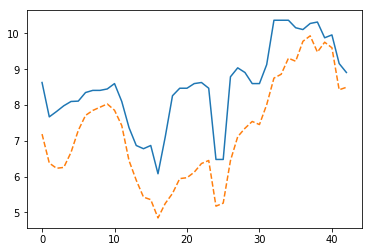

79 回目のループLinerRegression RMSE:  1.7519675801762267


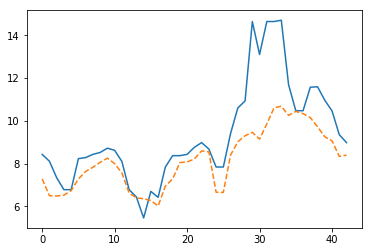

80 回目のループLinerRegression RMSE:  1.8031668828398288


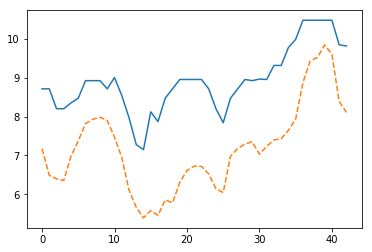

81 回目のループLinerRegression RMSE:  0.8359254161437262


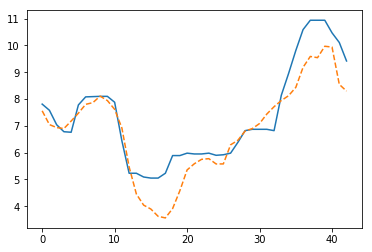

82 回目のループLinerRegression RMSE:  0.8258304891764822


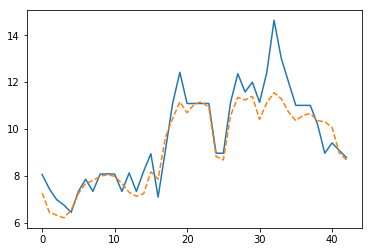

83 回目のループLinerRegression RMSE:  1.1411342777903073


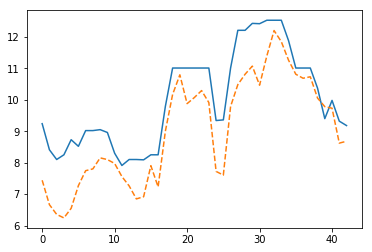

84 回目のループLinerRegression RMSE:  1.2746563070867254


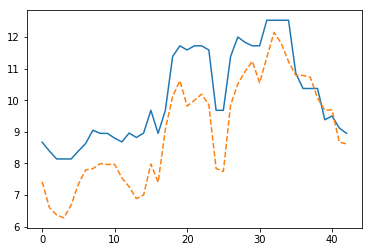

85 回目のループLinerRegression RMSE:  0.8915688222176388


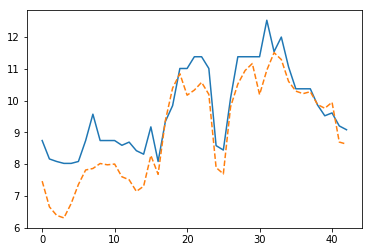

86 回目のループLinerRegression RMSE:  0.8582832671649171


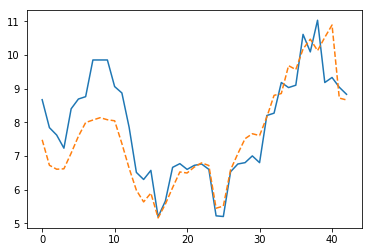

87 回目のループLinerRegression RMSE:  1.6976049779268978


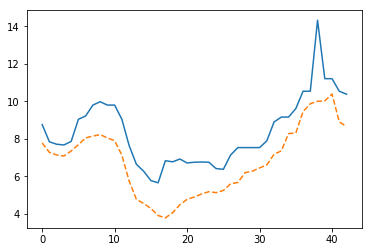

88 回目のループLinerRegression RMSE:  0.7491643471124965


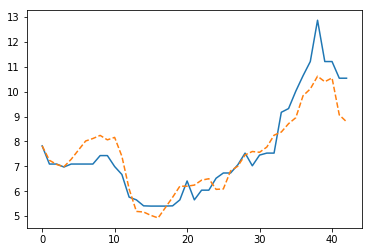

89 回目のループLinerRegression RMSE:  0.7066776808272797


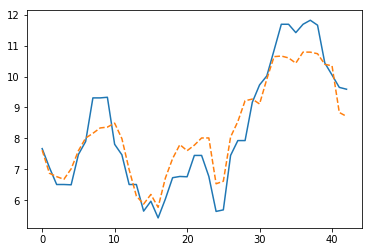

90 回目のループLinerRegression RMSE:  1.5180110706071783


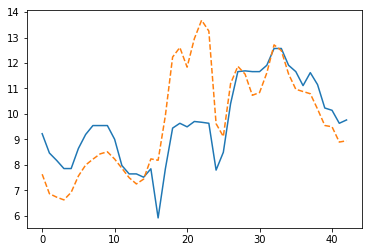

91 回目のループLinerRegression RMSE:  1.3700115974176135


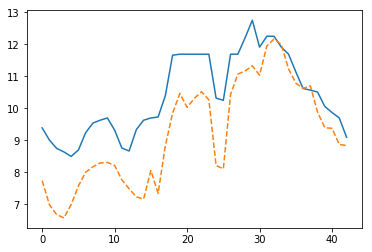

92 回目のループLinerRegression RMSE:  0.6602726368531319


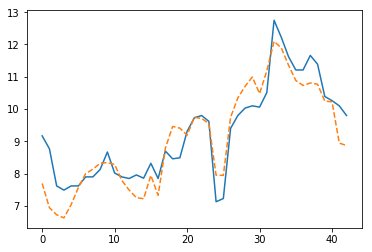

93 回目のループLinerRegression RMSE:  1.006971607484234


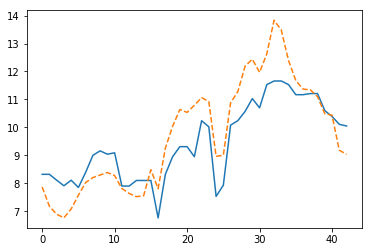

94 回目のループLinerRegression RMSE:  0.9844365507637285


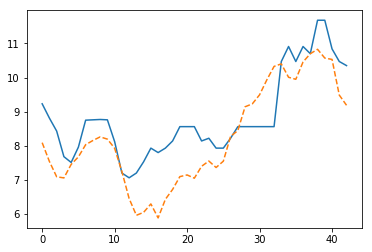

95 回目のループLinerRegression RMSE:  0.7938242930071


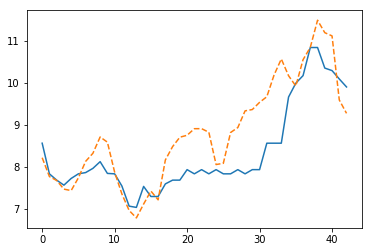

96 回目のループLinerRegression RMSE:  0.7341641823395344


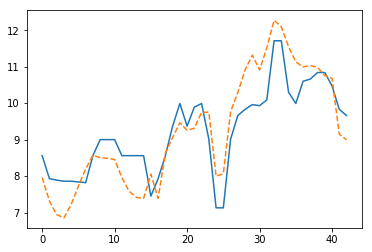

97 回目のループLinerRegression RMSE:  0.9490778538956248


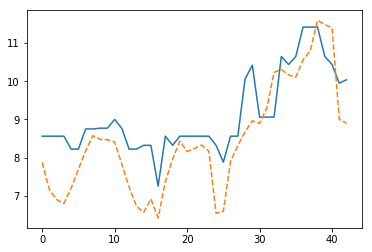

98 回目のループLinerRegression RMSE:  0.8949348376116186


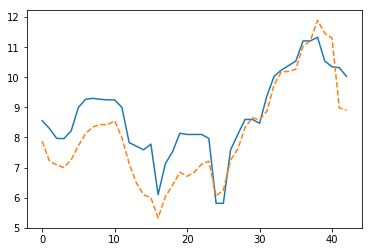

99 回目のループLinerRegression RMSE:  0.6151143862529029


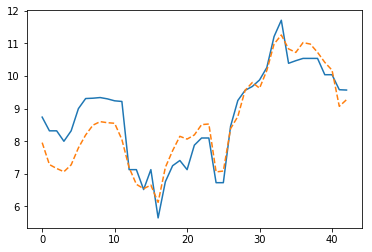

100 回目のループLinerRegression RMSE:  0.7895364092107291


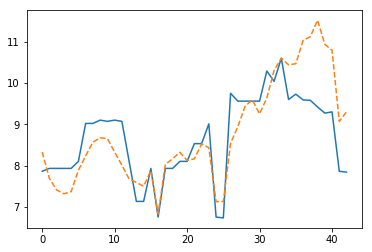

101 回目のループLinerRegression RMSE:  1.06557280003944


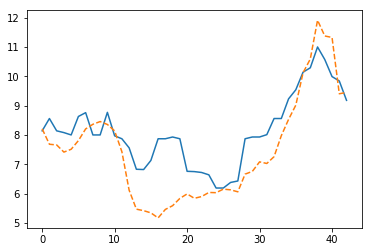

102 回目のループLinerRegression RMSE:  1.4423105326917207


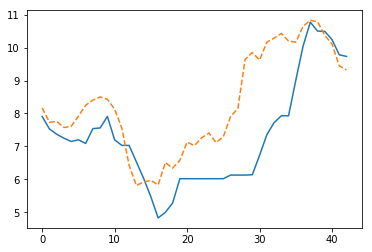

全体のLinerRegression RMSE:  1.8361312732538517


In [25]:
# "FCT_Dseries"と"targetprice_Dseries"を格納するBOXを定義
FCT_Dseries_BOX = []
targetprice_Dseries_BOX = []

##########################################################################################
### 日毎時系列プライスの予測vs実測を突き合わせて日毎のRMSEと予実グラフを描画するループ ###
##########################################################################################
for Dseries in range(FCT.shape[1]):
# 行列FCTのタテ↓方向(日毎時系列43コマ)データ"FCT_Dseries"集まれ
    FCT_Dseries = FCT[:,Dseries]
    FCT_Dseries_BOX.append(FCT_Dseries)
# 行列targetpriceのヨコ→方向(日毎時系列43コマ)データのtrainDAYs翌日から集まったデータ"targetprice_Dseries"
    targetprice_Dseries = targetprice[trainDAYs + Dseries]
    targetprice_Dseries_BOX.append(targetprice_Dseries)
# 日毎RMSEを計算
    lm_mse = mean_squared_error(targetprice_Dseries, FCT_Dseries)
    RMSE = np.sqrt(lm_mse)
    print(Dseries, "回目のループLinerRegression RMSE: ", RMSE)
# FCT_Tseries(予測プライス)とtargetprice_Dseries(実績プライス)をグラフで確認
    plt.plot(targetprice_Dseries)
    plt.plot(FCT_Dseries, linestyle = "dashed")
    plt.show()
    
# FCT_Dseries全部とtargetprice_Dseries全部で全体のRMSEを計算
lm_mse = mean_squared_error(targetprice_Dseries_BOX, FCT_Dseries_BOX)
RMSE = np.sqrt(lm_mse)
print("全体のLinerRegression RMSE: ", RMSE)

0.0 コマのLinerRegression RMSE:  1.2851168842178715


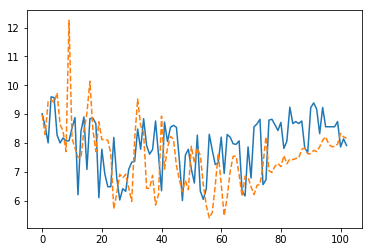

0.5 コマのLinerRegression RMSE:  1.229137142276304


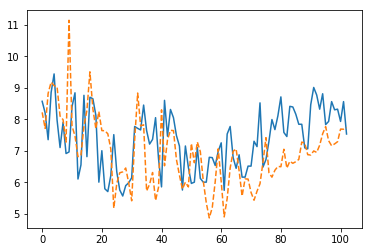

1.0 コマのLinerRegression RMSE:  1.1857920489590685


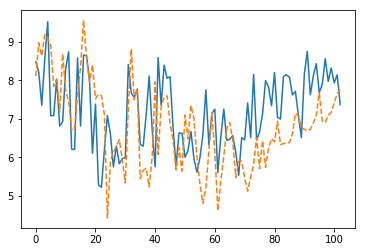

1.5 コマのLinerRegression RMSE:  1.0817989644166701


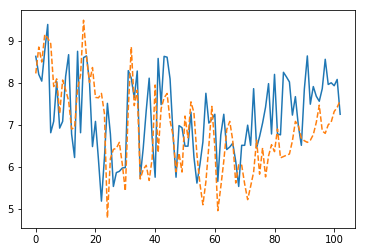

2.0 コマのLinerRegression RMSE:  0.9782955802205313


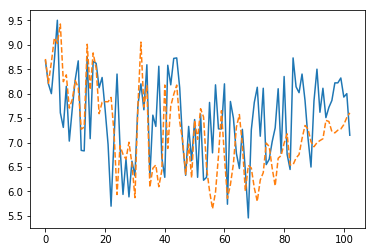

2.5 コマのLinerRegression RMSE:  0.888535624290854


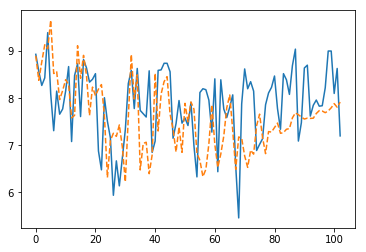

3.0 コマのLinerRegression RMSE:  0.8937215601615285


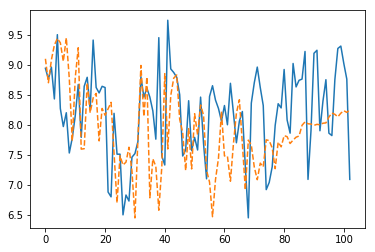

3.5 コマのLinerRegression RMSE:  0.9700744797715305


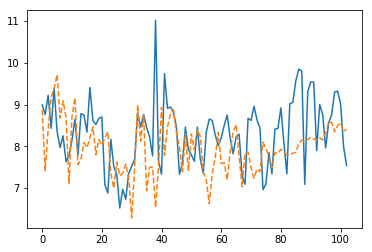

4.0 コマのLinerRegression RMSE:  1.0304583372505065


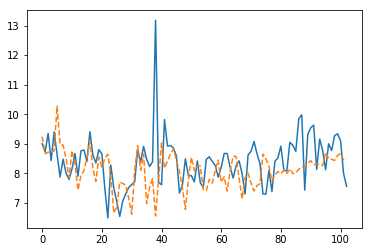

4.5 コマのLinerRegression RMSE:  1.0284391821849987


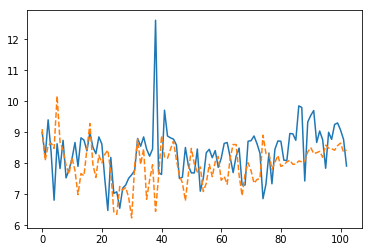

5.0 コマのLinerRegression RMSE:  0.958392913084458


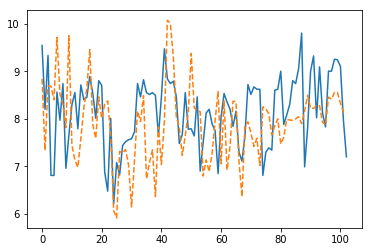

5.5 コマのLinerRegression RMSE:  1.0219030911807407


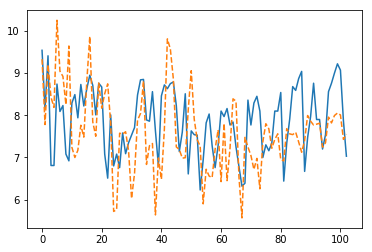

6.0 コマのLinerRegression RMSE:  1.3124517797299573


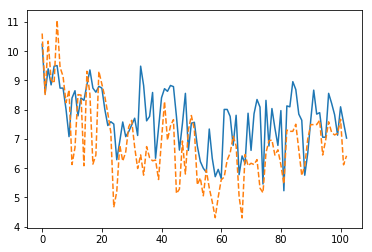

6.5 コマのLinerRegression RMSE:  1.7067971252413554


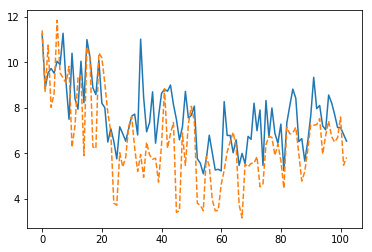

7.0 コマのLinerRegression RMSE:  2.1267442518037907


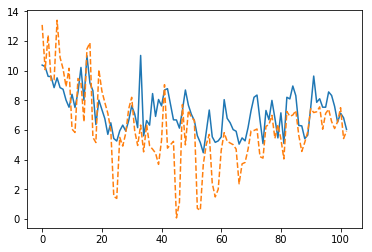

7.5 コマのLinerRegression RMSE:  2.463867285981289


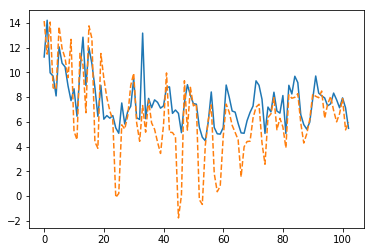

8.0 コマのLinerRegression RMSE:  2.2861378236479553


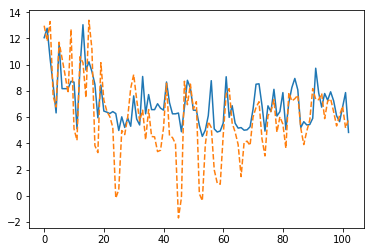

8.5 コマのLinerRegression RMSE:  2.6500946145878386


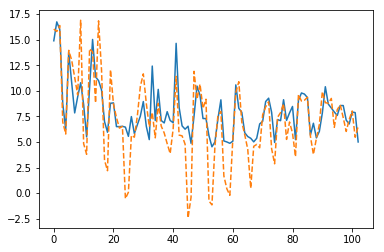

9.0 コマのLinerRegression RMSE:  2.6706517055768275


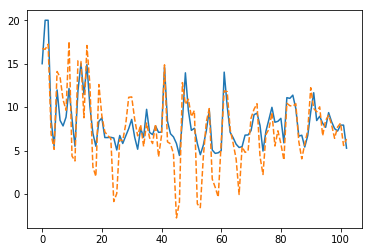

9.5 コマのLinerRegression RMSE:  2.5899861509814635


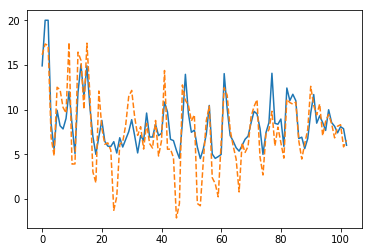

10.0 コマのLinerRegression RMSE:  1.9968402004421408


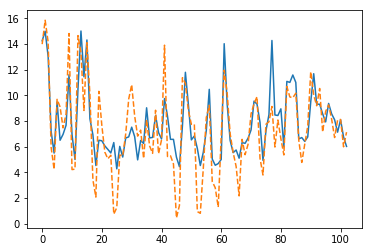

10.5 コマのLinerRegression RMSE:  1.8347346430440554


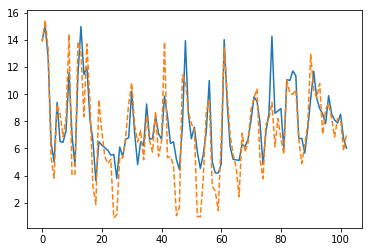

11.0 コマのLinerRegression RMSE:  1.8002006822506338


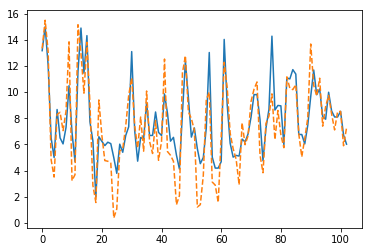

11.5 コマのLinerRegression RMSE:  1.728832750297676


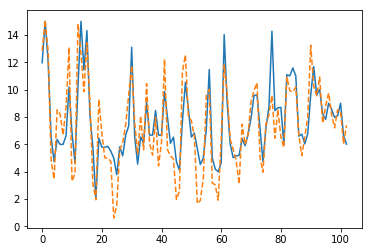

12.0 コマのLinerRegression RMSE:  1.1763331732870663


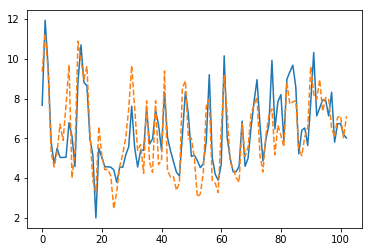

12.5 コマのLinerRegression RMSE:  1.106839952114127


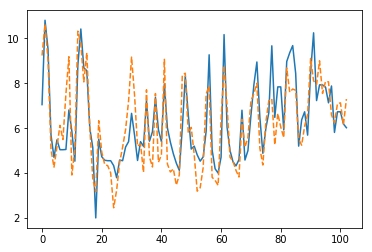

13.0 コマのLinerRegression RMSE:  1.5483837298333973


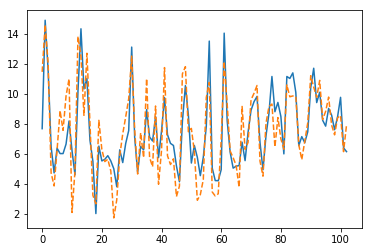

13.5 コマのLinerRegression RMSE:  1.6387443024187511


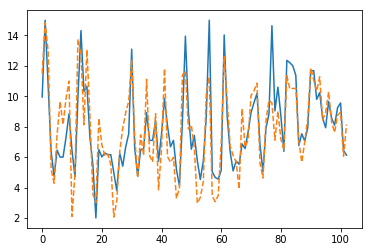

14.0 コマのLinerRegression RMSE:  1.662517267047518


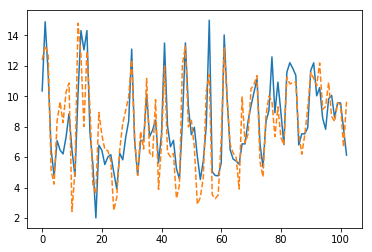

14.5 コマのLinerRegression RMSE:  1.7665853727754781


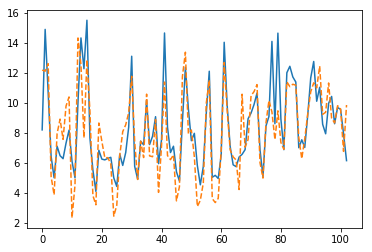

15.0 コマのLinerRegression RMSE:  1.55140889788106


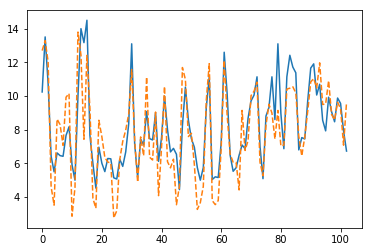

15.5 コマのLinerRegression RMSE:  1.836677510537537


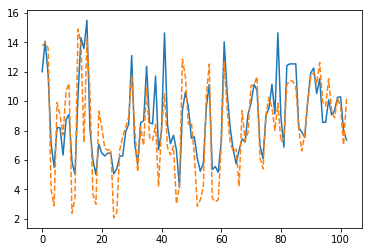

16.0 コマのLinerRegression RMSE:  2.078097231940748


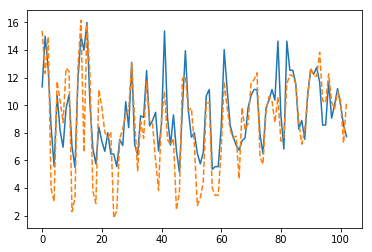

16.5 コマのLinerRegression RMSE:  2.3868265139742735


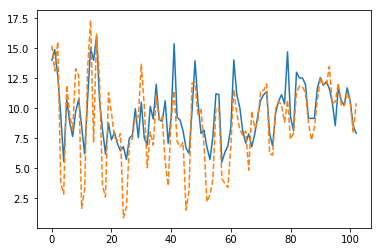

17.0 コマのLinerRegression RMSE:  2.3925537533413554


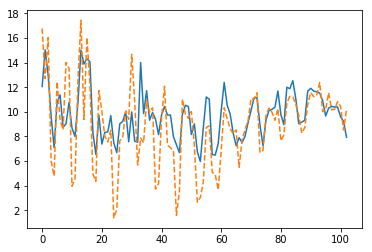

17.5 コマのLinerRegression RMSE:  2.8892792315844797


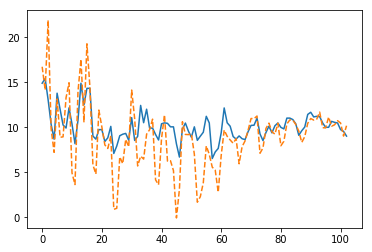

18.0 コマのLinerRegression RMSE:  2.8716540819387237


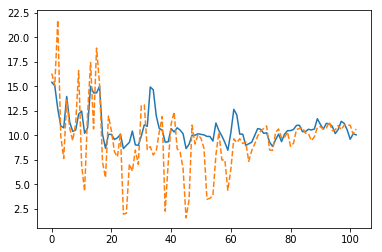

18.5 コマのLinerRegression RMSE:  2.9501137856333366


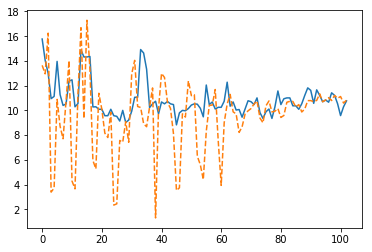

19.0 コマのLinerRegression RMSE:  2.4350709988712476


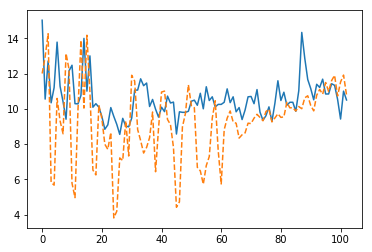

19.5 コマのLinerRegression RMSE:  1.8600407794286262


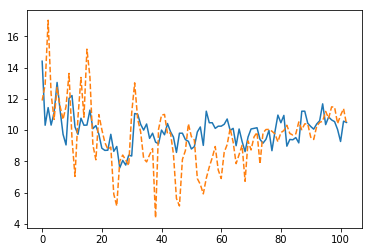

20.0 コマのLinerRegression RMSE:  1.7373518896006228


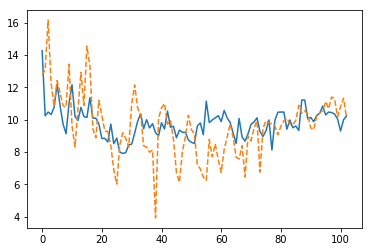

20.5 コマのLinerRegression RMSE:  1.4702889727579855


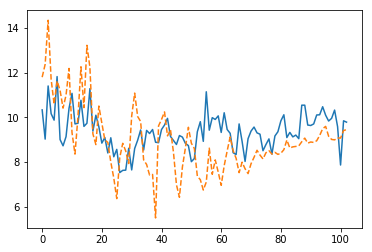

21.0 コマのLinerRegression RMSE:  1.3401094147286448


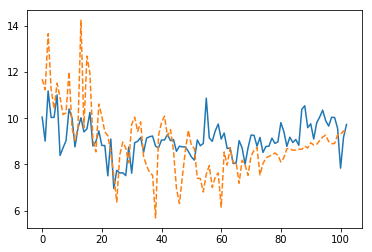

In [26]:
# "FCT_Tseries"と"targetprice_Tseries"を格納するBOXを定義
FCT_Tseries_BOX = []
targetprice_Tseries_BOX = []
RMSE_Tseries_BOX = []#Excelグラフ用

############################################################################################
### 日毎時系列プライスの予測vs実績を突き合わせてコマ毎のRMSEと予実グラフを描画するループ ###
############################################################################################
for Tseries in range(len(TcomaTcode21)):
# 行列FCTのヨコ→方向(コマ毎日系列)データ"FCT_Tseries"集まれ
    FCT_Tseries = FCT[Tseries,:]
    FCT_Tseries_BOX.append(FCT_Tseries)
# 行列targetpriceのタテ↓方向(コマ毎日系列)データのtrainDAYs翌日から集まったデータ"targetprice_Tseries"
    targetprice_Tseries = targetprice[trainDAYs:, Tseries]
    targetprice_Tseries_BOX.append(targetprice_Tseries)
# コマ毎RMSEを計算
    lm_mse = mean_squared_error(targetprice_Tseries, FCT_Tseries)
    RMSE = np.sqrt(lm_mse)
    RMSE_Tseries_BOX.append(RMSE)
    print(Tseries / 2, "コマのLinerRegression RMSE: ", RMSE)
# FCT_Tseries(予測プライス)とtargetprice_Tseries(実績プライス)をグラフで確認
    plt.plot(targetprice_Tseries)
    plt.plot(FCT_Tseries, linestyle = "dashed")
    plt.show()

In [21]:
np.savetxt("4th_LR_RMSE.csv", RMSE_Tseries_BOX, delimiter=",")

### 【ランダムフォレスト】

In [21]:
# 特徴量の重要度のdef
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

In [22]:
JEPXdf_ORG.head()

Tcode  Kyusyu_Price  Weekday                      YMDHM  \
0      1          9.77        3  2017-12-07 00:00:00+09:00   
1      2          9.52        3  2017-12-07 00:30:00+09:00   
2      3          9.52        3  2017-12-07 01:00:00+09:00   
3      4          9.27        3  2017-12-07 01:30:00+09:00   
4      5          9.36        3  2017-12-07 02:00:00+09:00   

                   DateTime  DSWRF_fukuoka  TMP_fukuoka  TMPdiff_fukuoka  \
0 2017-12-06 15:00:00+00:00            0.0         6.81            13.19   
1 2017-12-06 15:30:00+00:00            0.0         6.73            13.27   
2 2017-12-06 16:00:00+00:00            0.0         6.65            13.35   
3 2017-12-06 16:30:00+00:00            0.0         6.64            13.36   
4 2017-12-06 17:00:00+00:00            0.0         6.63            13.37   

   APCP_fukuoka  RH_fukuoka        ...         APCP_miyazaki  RH_miyazaki  \
0           0.0       62.32        ...                   0.0        60.34   
1           0.0       62.34        ...                   0.0        60.46   
2           0.0       62.37        ...                   0.0        60.59   
3           0.0       61.86        ...                   0.0        60.22   
4           0.0       61.36        ...                   0.0        59.86   

   DSWRF_kagoshima  TMP_kagoshima  TMPdiff_kagoshima  APCP_kagoshima  \
0              0.0           7.65              12.35             0.0   
1              0.0           7.54              12.46             0.0   
2              0.0           7.43              12.57             0.0   
3              0.0           7.34              12.66             0.0   
4              0.0           7.25              12.75             0.0   

   RH_kagoshima  OnOff_OFF  OnOff_ON  Moving_Ave_Price  
0         62.99          0         1              9.77  
1         63.56          0         1              9.52  
2         64.12          0         1              9.52  
3         64.03          0         1              9.27  
4         63.94          0         1              9.36  

[5 rows x 43 columns]

///  0.0 コマ ///


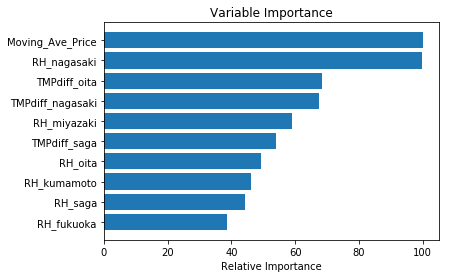

///  0.5 コマ ///


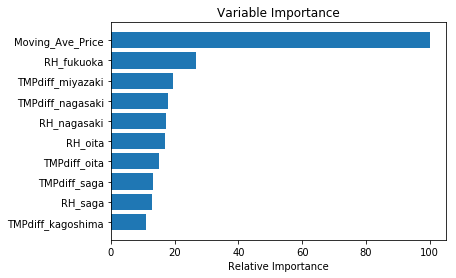

///  1.0 コマ ///


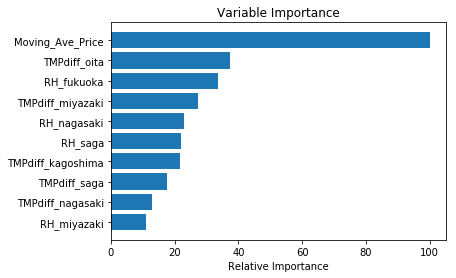

///  1.5 コマ ///


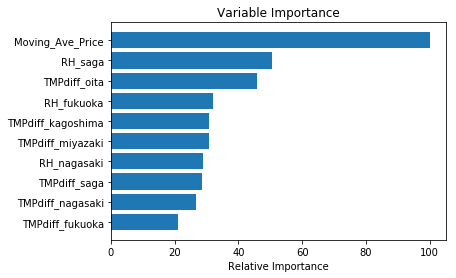

///  2.0 コマ ///


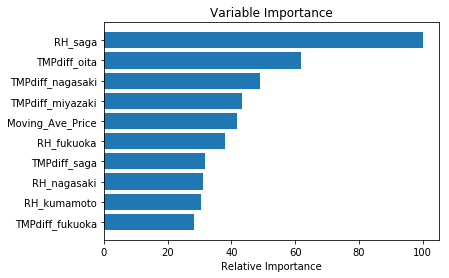

///  2.5 コマ ///


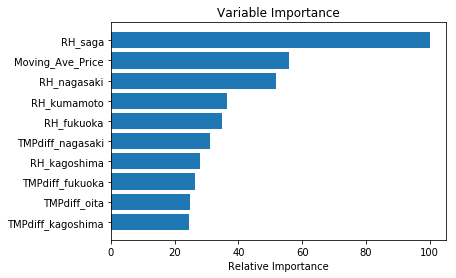

///  3.0 コマ ///


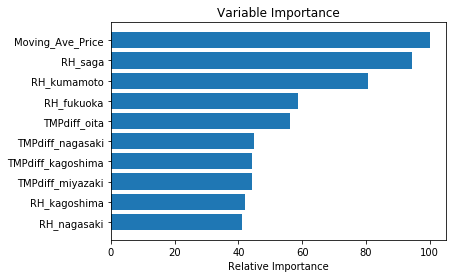

///  3.5 コマ ///


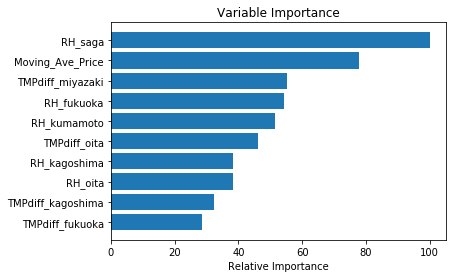

///  4.0 コマ ///


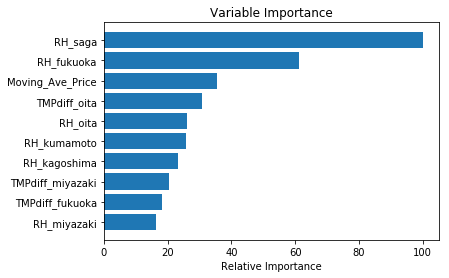

///  4.5 コマ ///


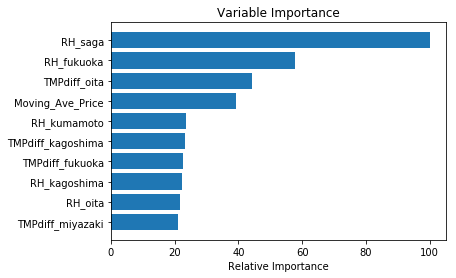

///  5.0 コマ ///


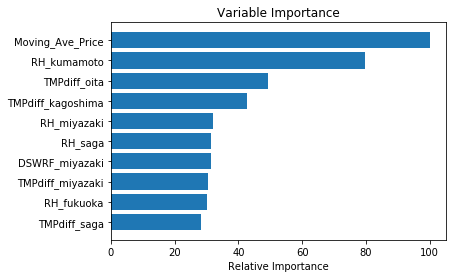

///  5.5 コマ ///


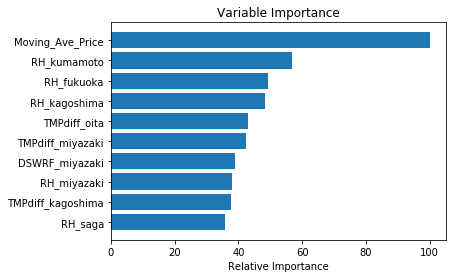

///  6.0 コマ ///


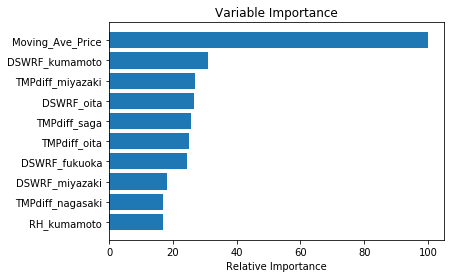

///  6.5 コマ ///


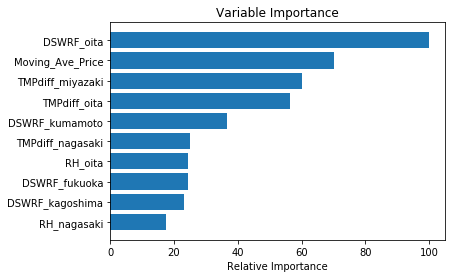

///  7.0 コマ ///


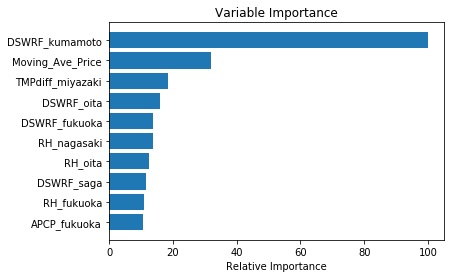

///  7.5 コマ ///


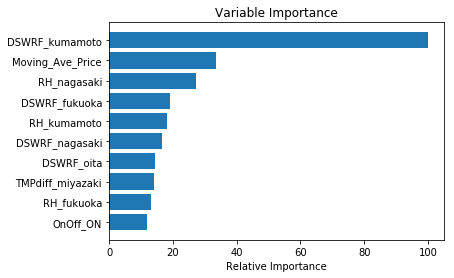

///  8.0 コマ ///


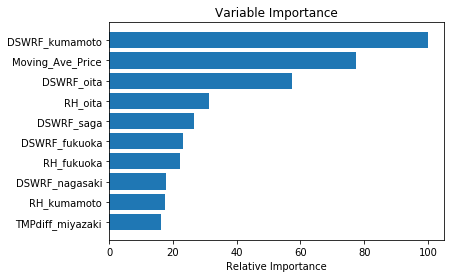

///  8.5 コマ ///


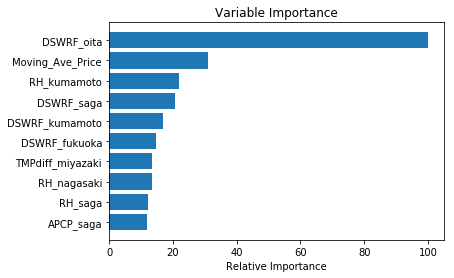

///  9.0 コマ ///


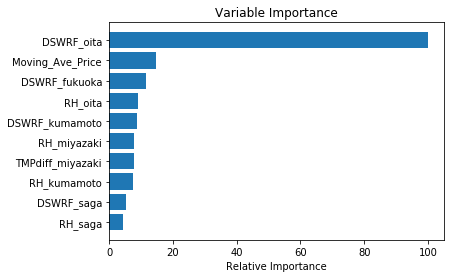

///  9.5 コマ ///


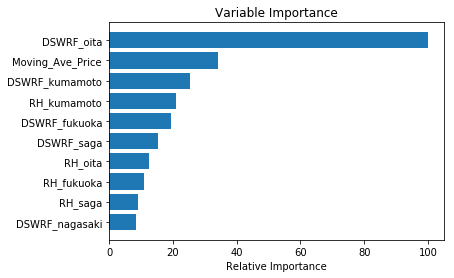

///  10.0 コマ ///


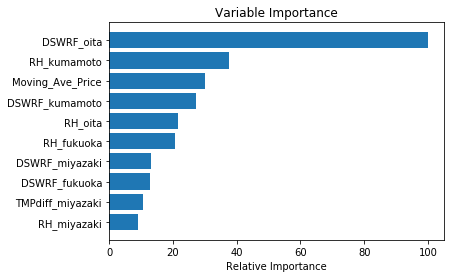

///  10.5 コマ ///


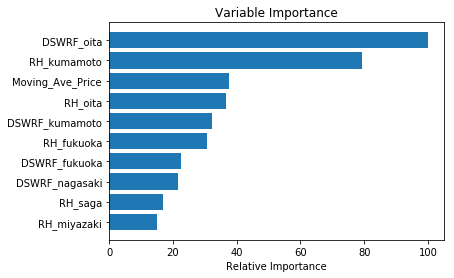

///  11.0 コマ ///


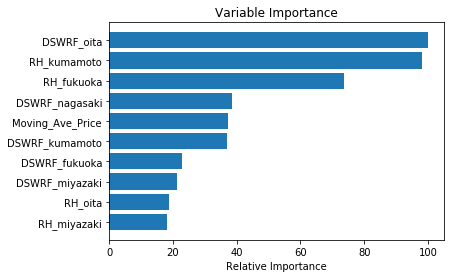

///  11.5 コマ ///


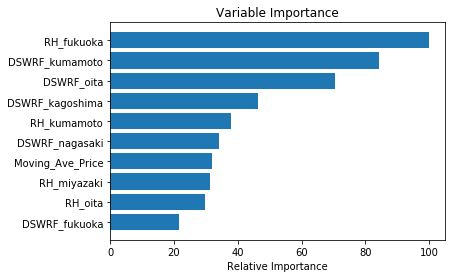

///  12.0 コマ ///


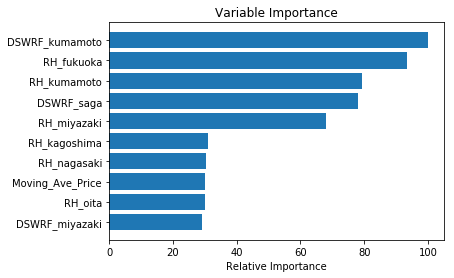

///  12.5 コマ ///


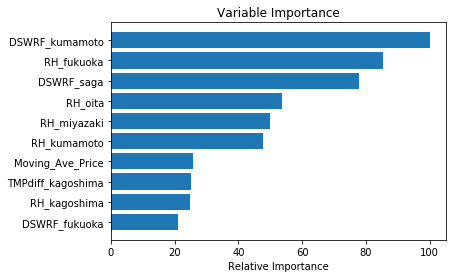

///  13.0 コマ ///


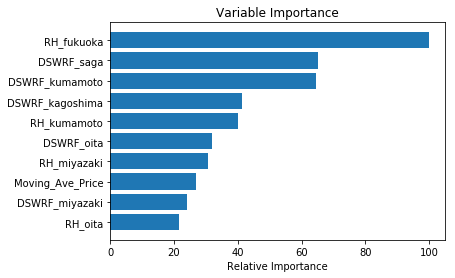

///  13.5 コマ ///


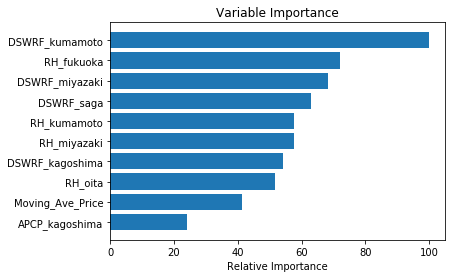

///  14.0 コマ ///


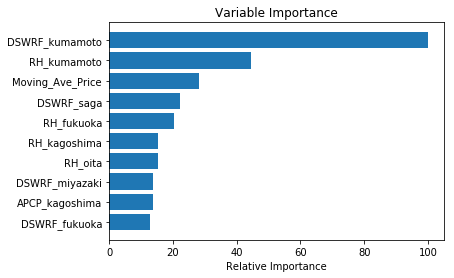

///  14.5 コマ ///


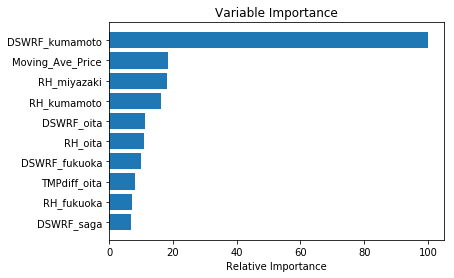

///  15.0 コマ ///


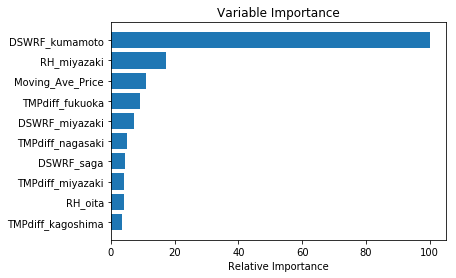

///  15.5 コマ ///


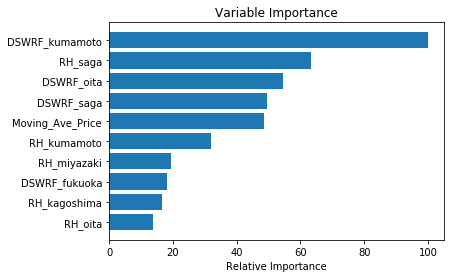

///  16.0 コマ ///


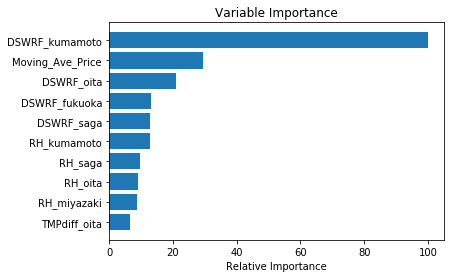

///  16.5 コマ ///


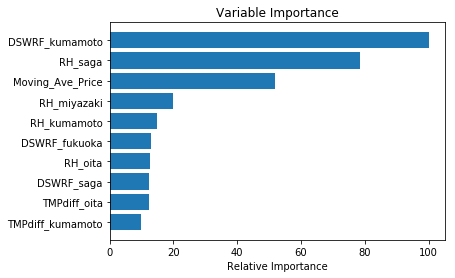

///  17.0 コマ ///


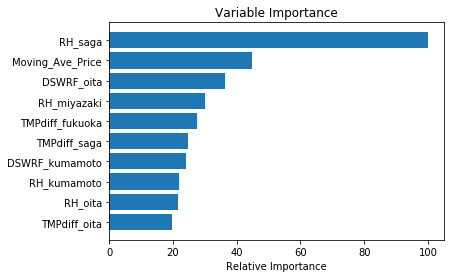

///  17.5 コマ ///


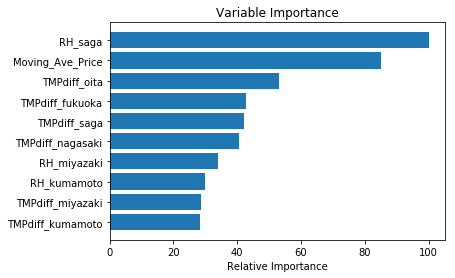

///  18.0 コマ ///


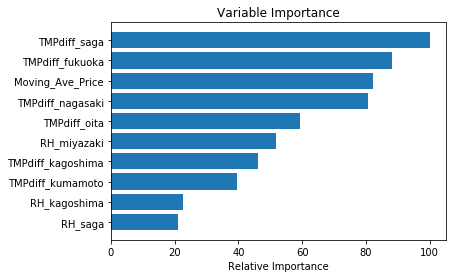

///  18.5 コマ ///


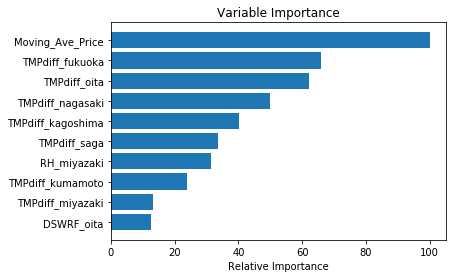

///  19.0 コマ ///


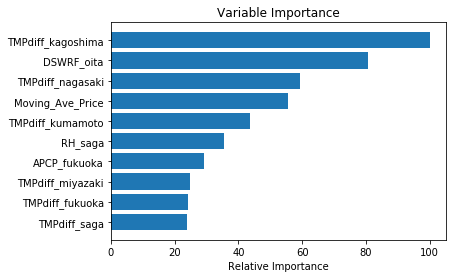

///  19.5 コマ ///


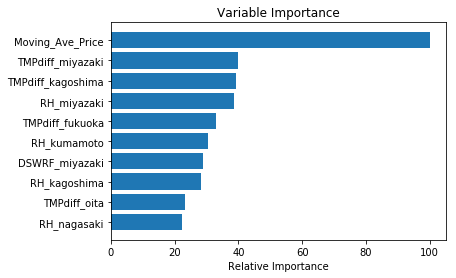

///  20.0 コマ ///


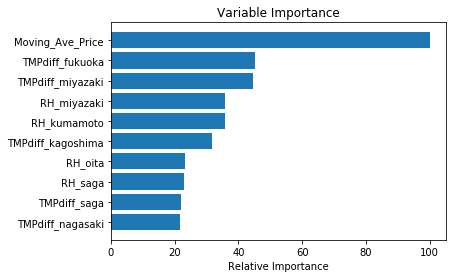

///  20.5 コマ ///


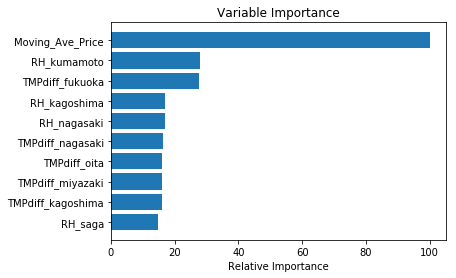

///  21.0 コマ ///


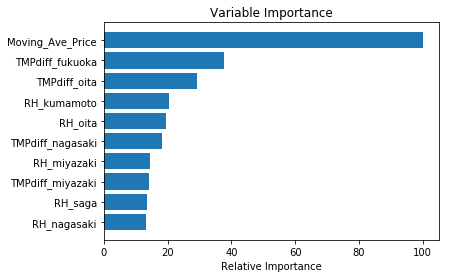

In [23]:
# 予測値を格納するリストを"FCT"と定義
FCT = np.array([])

########################################
### 予測ターゲット列と特徴量列を指定 ###
########################################
target_col = "Kyusyu_Price"
exclude_cols = ["Tcode", "Kyusyu_Price", "Weekday", "YMDHM", "DateTime", \
                "TMP_fukuoka", "TMP_saga", "TMP_nagasaki", "TMP_kumamoto", "TMP_oita", "TMP_miyazaki", "TMP_kagoshima"]
feature_cols = [col for col in JEPXdf_ORG.columns if col not in exclude_cols]

################################
### 予測対象時刻コマのループ ###
################################
for Tcoma in TcomaTcode21:
    Tcode = TcomaTcode21[Tcoma]
    
# 時刻コードでソートしたデータフレームを"JEPX_T"と定義してインデックスをリセット
    JEPXdf_T = JEPXdf_ORG[JEPXdf_ORG["Tcode"] == Tcode].reset_index(drop=True)

##############################
### ローリング学習のループ ###
##############################
# 学習データ(上からtrainDAYs行) + 教師データ(最尾1行) のデータフレームを"JEPXdf_FCT"と定義
    for i in range(len(JEPXdf_T)-trainDAYs):
        JEPXdf_FCT = JEPXdf_T[i:trainDAYs+1+i].reset_index(drop=True)

        # 機械学習アルゴリズムに投入するためNumPy配列にする
        y_train = np.array(JEPXdf_FCT[target_col][0:trainDAYs])
        X_train = np.array(JEPXdf_FCT[feature_cols][0:trainDAYs])
        y_test = np.array(JEPXdf_FCT[target_col][trainDAYs:])
        X_test = np.array(JEPXdf_FCT[feature_cols][trainDAYs:])   

##############################
### ランダムフォレスト投入 ###
##############################
        ## グリッドサーチでハイパーパラメータのチューニング
#         rf = RandomForestRegressor(random_state=0)
#         params = {'n_estimators' :[150, 200, 250], 'max_depth':[5, 10, None], 'max_features':[10, 20, 'auto']}
#         gcv = GridSearchCV(rf, param_grid=params, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', verbose=0)
#         gcv.fit(X_train, y_train)
#         print( gcv.best_params_ )
        
#         rf = RandomForestRegressor(**gcv.best_params_, random_state=0)
        rf = RandomForestRegressor(n_estimators=150, max_depth=None, max_features="auto", n_jobs=-1, random_state=0)
#         rf = Ridge(random_state=0)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        FCT = np.r_[FCT, y_pred]
    
# 特徴量の重要度をコマ毎に確認
    print("/// ", (Tcode-1)/2, "コマ ///")
    varImpPlot(rf, feature_cols, topN=10, verbose=False)

# 1次元配列のFCTを、行数:時刻コマ数(=43)、列数:予測対象日数(学習日数によって変化するので-1)の2次元配列にする
FCT = np.reshape(FCT, (len(TcomaTcode21), -1))

In [71]:
#rf = RandomForestRegressor(n_estimators=150, max_depth=None, max_features=10, n_jobs=-1, random_state=0)
np.sqrt( mean_squared_error(targetprice[trainDAYs:], FCT.T) )
# print( targetprice[trainDAYs:].shape)
# print( FCT.T.shape )


1.5883774982217167

In [108]:
#rf = RandomForestRegressor(n_estimators=150, max_depth=None, max_features="auto", n_jobs=-1, random_state=0)
#移動平均を特徴量に入れた
np.sqrt( mean_squared_error(targetprice[trainDAYs:], FCT.T) )

1.3821878230178755

In [112]:
#
np.sqrt( mean_squared_error(targetprice[trainDAYs:], FCT.T) )

1.3826425019154296

0 回目のループRandom Forest RMSE:  2.4323429601015465


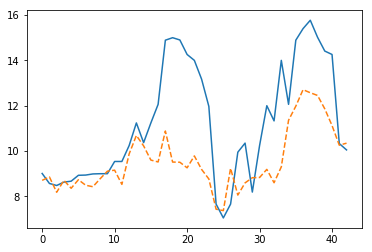

1 回目のループRandom Forest RMSE:  2.411883876880383


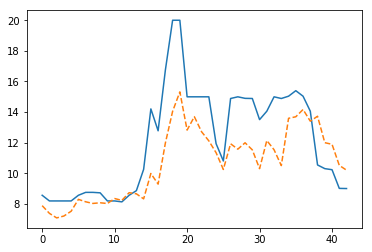

2 回目のループRandom Forest RMSE:  2.3618259375703037


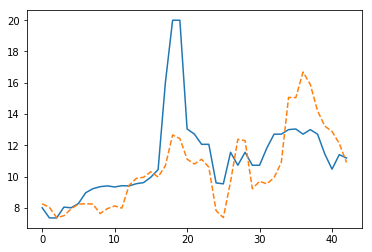

3 回目のループRandom Forest RMSE:  1.7505962135938415


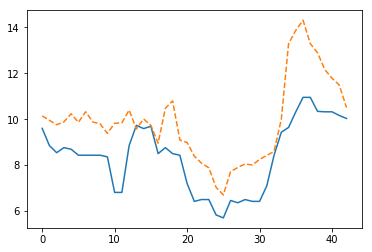

4 回目のループRandom Forest RMSE:  2.2232548768045346


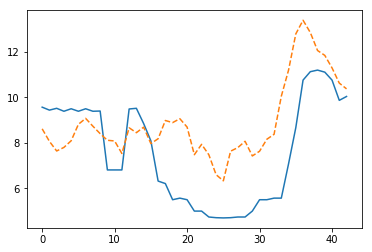

5 回目のループRandom Forest RMSE:  2.0569310641302434


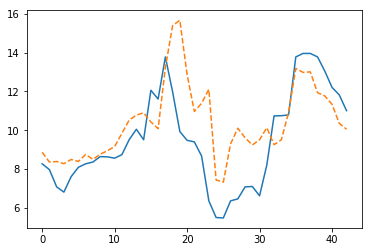

6 回目のループRandom Forest RMSE:  2.224841430414976


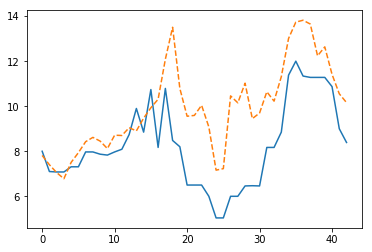

7 回目のループRandom Forest RMSE:  1.77877111030126


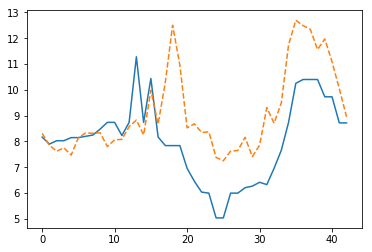

8 回目のループRandom Forest RMSE:  1.6467801903559678


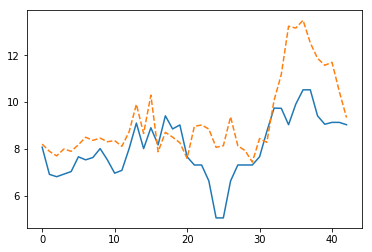

9 回目のループRandom Forest RMSE:  1.0923209185234561


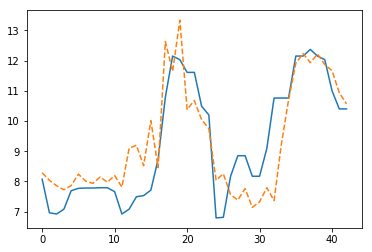

10 回目のループRandom Forest RMSE:  1.086442214656681


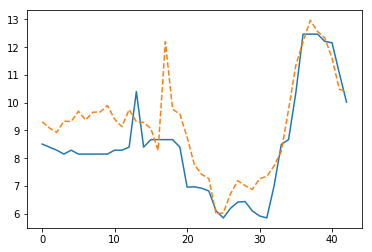

11 回目のループRandom Forest RMSE:  2.277130274019885


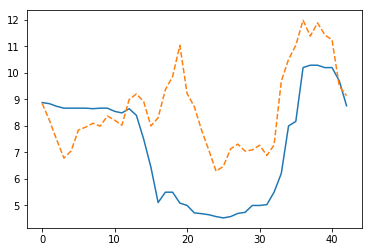

12 回目のループRandom Forest RMSE:  1.46329630003818


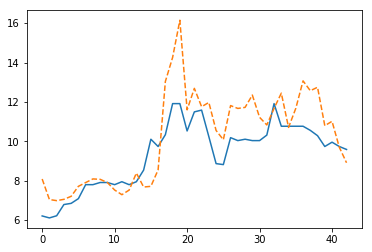

13 回目のループRandom Forest RMSE:  2.902911401393621


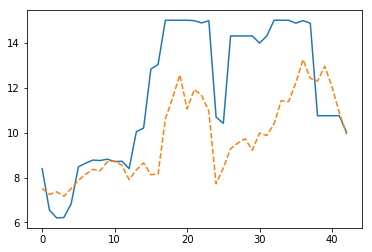

14 回目のループRandom Forest RMSE:  1.4088975786704518


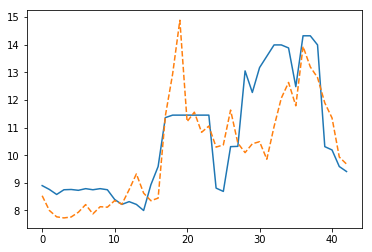

15 回目のループRandom Forest RMSE:  1.912123203840868


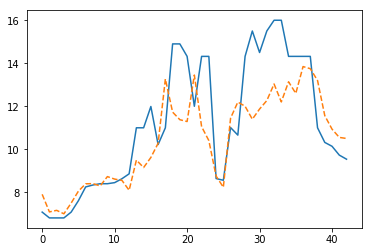

16 回目のループRandom Forest RMSE:  1.6920050945244327


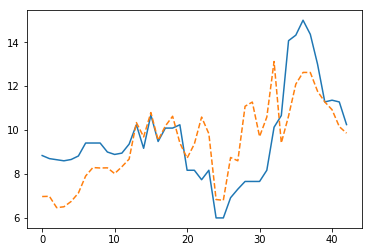

17 回目のループRandom Forest RMSE:  1.1364791573270336


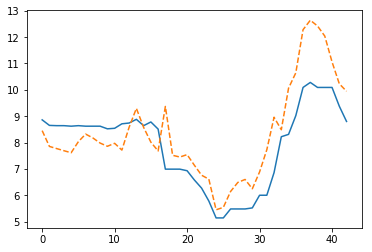

18 回目のループRandom Forest RMSE:  2.166672676008362


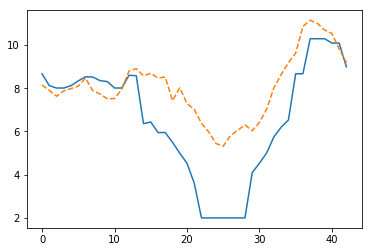

19 回目のループRandom Forest RMSE:  1.5096184014973892


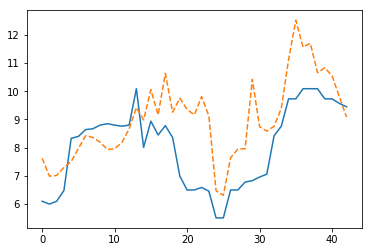

20 回目のループRandom Forest RMSE:  1.1429978441498774


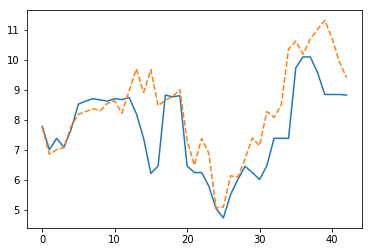

21 回目のループRandom Forest RMSE:  1.0424671997888753


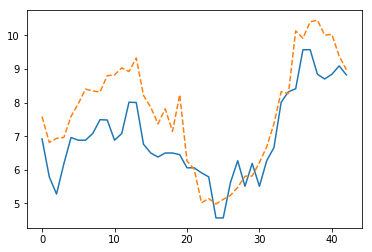

22 回目のループRandom Forest RMSE:  1.1981540767480228


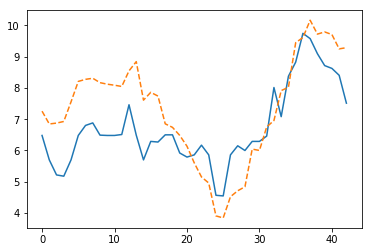

23 回目のループRandom Forest RMSE:  0.7143989396417383


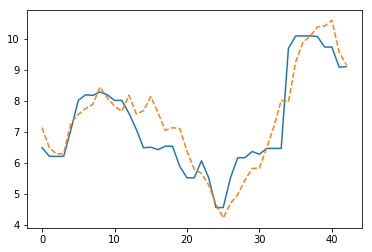

24 回目のループRandom Forest RMSE:  1.0153394419235287


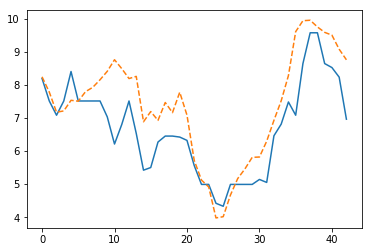

25 回目のループRandom Forest RMSE:  1.3985118189347767


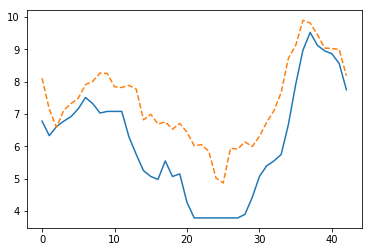

26 回目のループRandom Forest RMSE:  0.8763481537104015


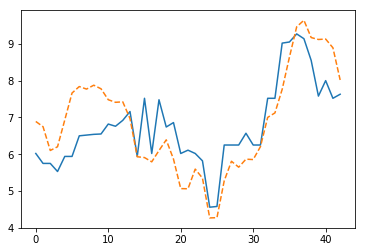

27 回目のループRandom Forest RMSE:  1.4357981844825223


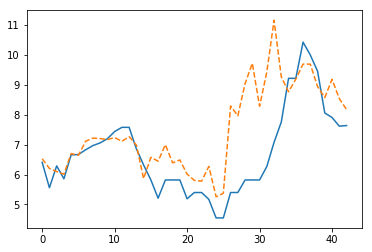

28 回目のループRandom Forest RMSE:  0.9773307829106808


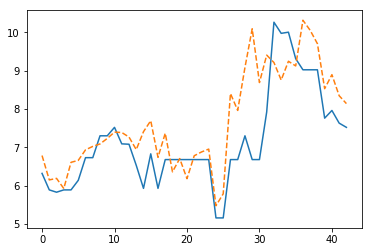

29 回目のループRandom Forest RMSE:  1.8764142159912778


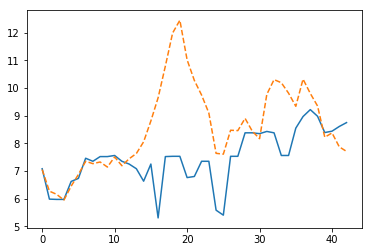

30 回目のループRandom Forest RMSE:  2.0724950797795865


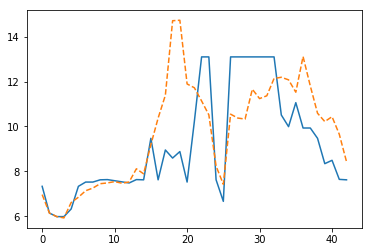

31 回目のループRandom Forest RMSE:  2.1840524870409763


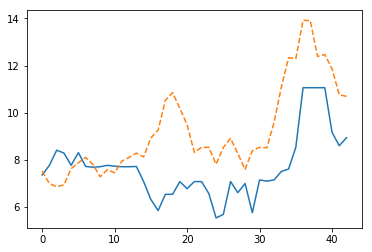

32 回目のループRandom Forest RMSE:  1.493073180862497


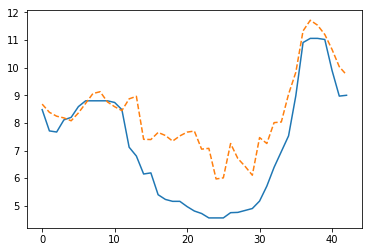

33 回目のループRandom Forest RMSE:  2.4146669460959784


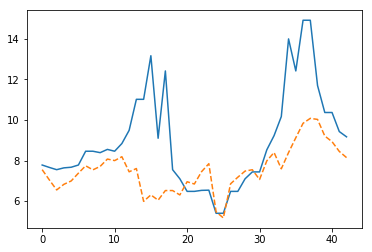

34 回目のループRandom Forest RMSE:  1.2751973784902975


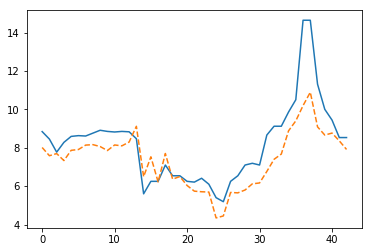

35 回目のループRandom Forest RMSE:  1.423400623030428


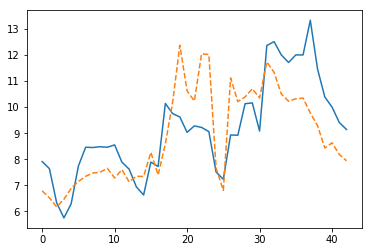

36 回目のループRandom Forest RMSE:  0.7153088974058769


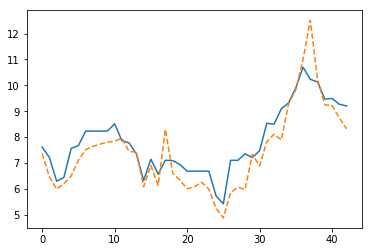

37 回目のループRandom Forest RMSE:  1.0386711784041878


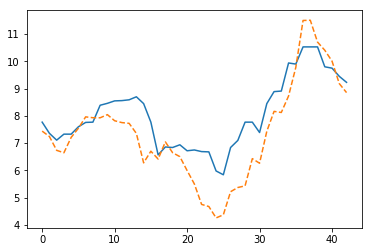

38 回目のループRandom Forest RMSE:  2.111392049567476


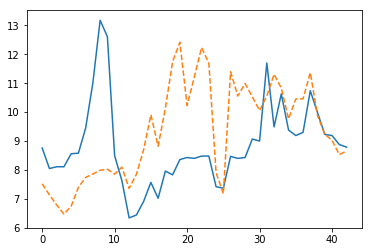

39 回目のループRandom Forest RMSE:  1.0476202505953034


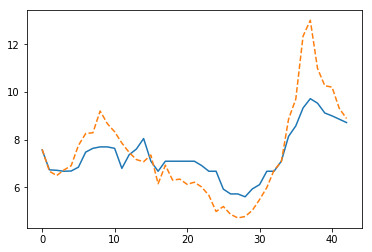

40 回目のループRandom Forest RMSE:  0.8714530923672148


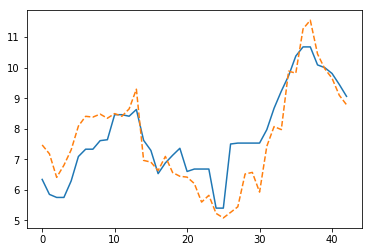

41 回目のループRandom Forest RMSE:  1.9818702392095708


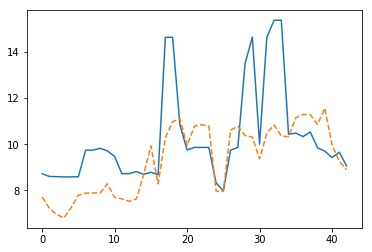

42 回目のループRandom Forest RMSE:  1.2632774926604733


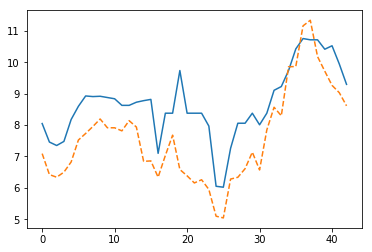

43 回目のループRandom Forest RMSE:  0.885478503263406


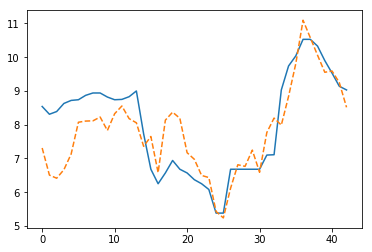

44 回目のループRandom Forest RMSE:  0.6308499985100713


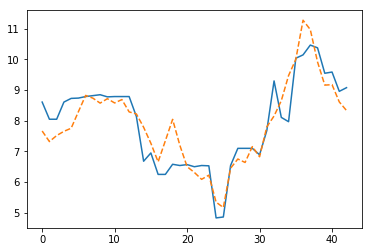

45 回目のループRandom Forest RMSE:  0.9348197808877506


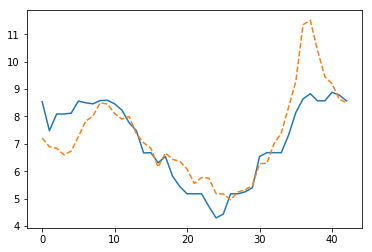

46 回目のループRandom Forest RMSE:  1.227325054732511


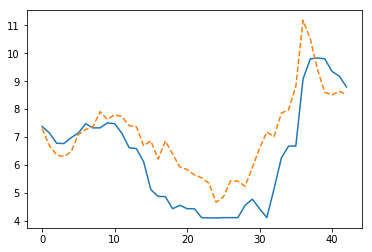

47 回目のループRandom Forest RMSE:  1.4615294920472968


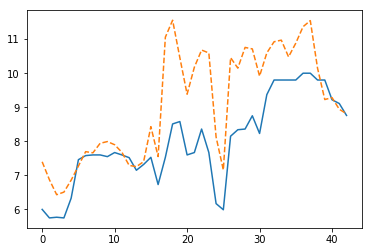

48 回目のループRandom Forest RMSE:  1.3796189200081468


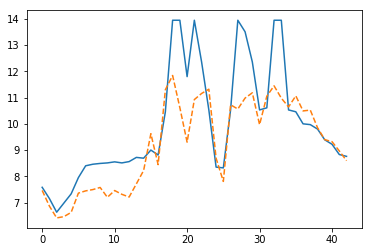

49 回目のループRandom Forest RMSE:  1.169413160587411


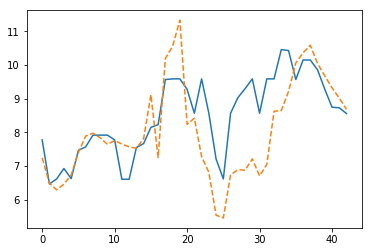

50 回目のループRandom Forest RMSE:  0.8956524077763396


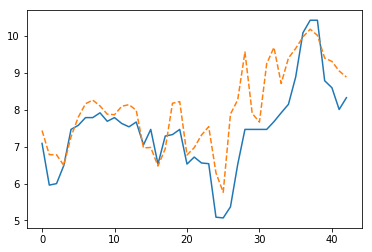

51 回目のループRandom Forest RMSE:  0.8397397776455547


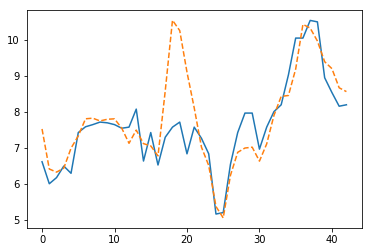

52 回目のループRandom Forest RMSE:  0.719298707631978


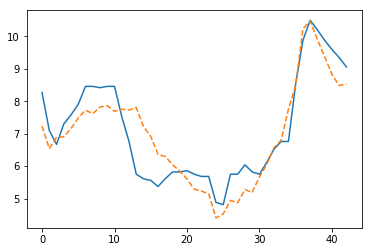

53 回目のループRandom Forest RMSE:  1.0425579095820243


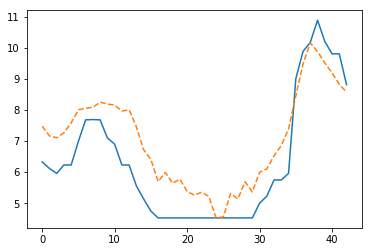

54 回目のループRandom Forest RMSE:  1.3045478151312906


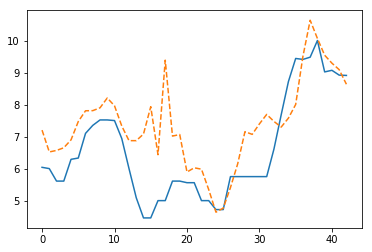

55 回目のループRandom Forest RMSE:  1.2769751972403078


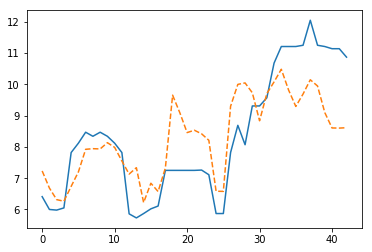

56 回目のループRandom Forest RMSE:  1.5381343171423822


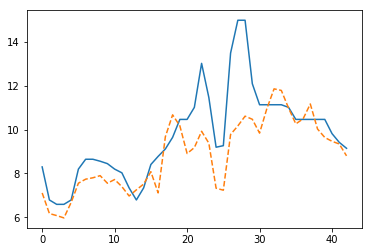

57 回目のループRandom Forest RMSE:  0.8172751415226724


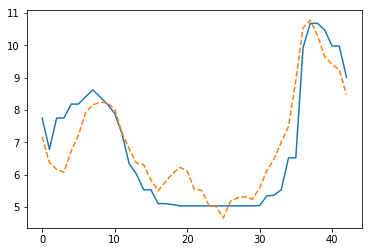

58 回目のループRandom Forest RMSE:  0.6063327924447076


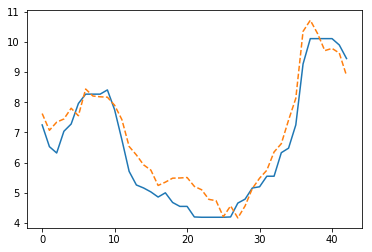

59 回目のループRandom Forest RMSE:  0.65263639603255


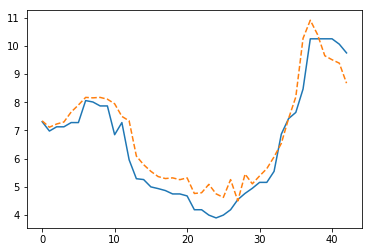

60 回目のループRandom Forest RMSE:  1.9314549630831679


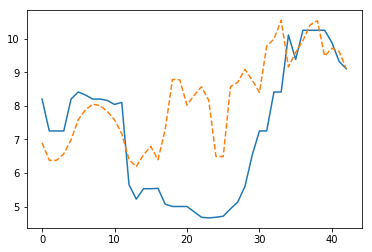

61 回目のループRandom Forest RMSE:  1.5979544802434877


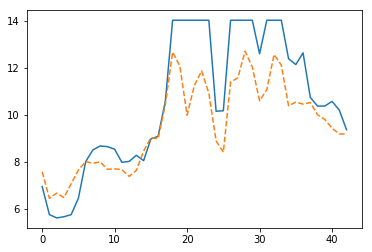

62 回目のループRandom Forest RMSE:  1.0361459487849487


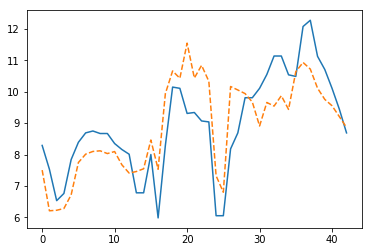

63 回目のループRandom Forest RMSE:  0.6944045458388456


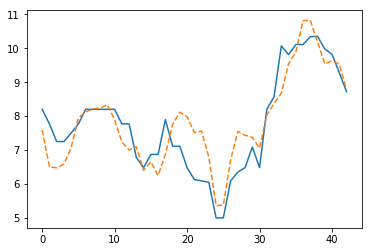

64 回目のループRandom Forest RMSE:  0.8763404897965442


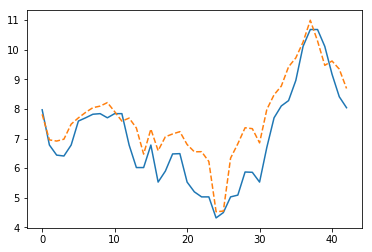

65 回目のループRandom Forest RMSE:  0.7081830028163884


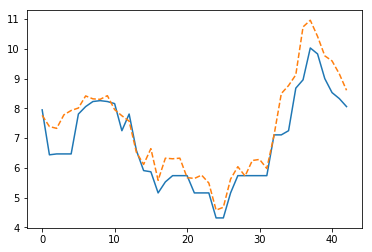

66 回目のループRandom Forest RMSE:  0.49202593028452574


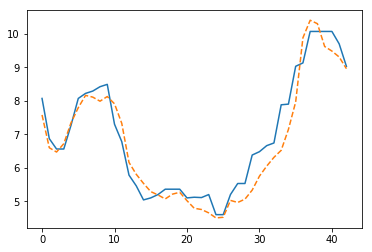

67 回目のループRandom Forest RMSE:  2.3331926814086352


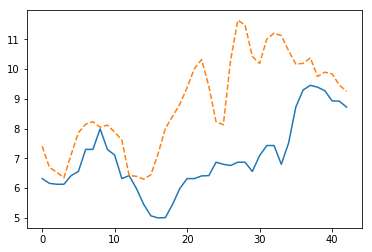

68 回目のループRandom Forest RMSE:  0.7386249797237003


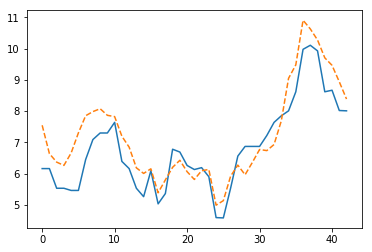

69 回目のループRandom Forest RMSE:  1.07281881172484


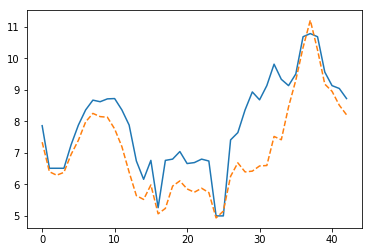

70 回目のループRandom Forest RMSE:  0.706265171083994


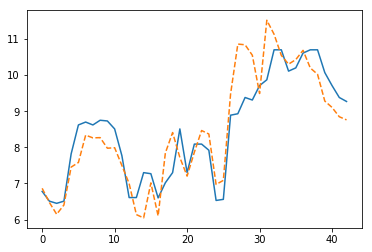

71 回目のループRandom Forest RMSE:  0.8469379504345687


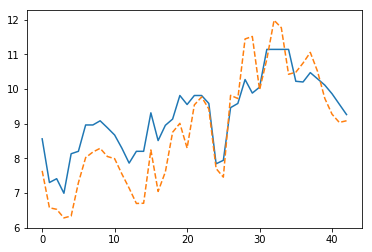

72 回目のループRandom Forest RMSE:  0.5806844202022587


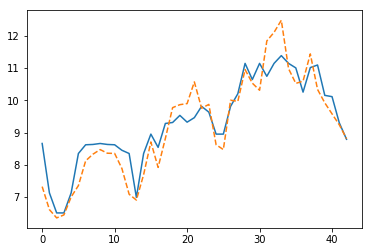

73 回目のループRandom Forest RMSE:  1.0876411026461708


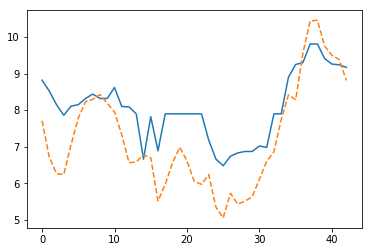

74 回目のループRandom Forest RMSE:  0.9366660401664152


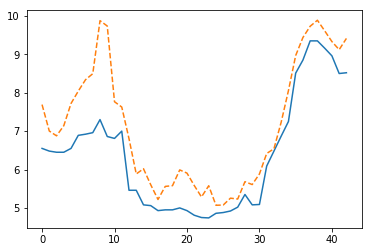

75 回目のループRandom Forest RMSE:  0.6664047365289484


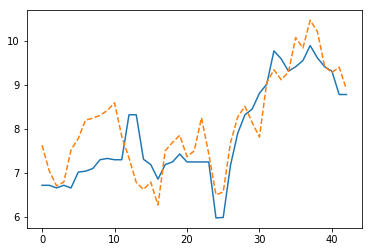

76 回目のループRandom Forest RMSE:  0.7650151696660159


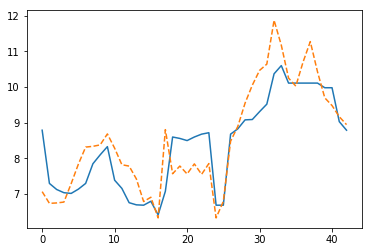

77 回目のループRandom Forest RMSE:  2.178355430099727


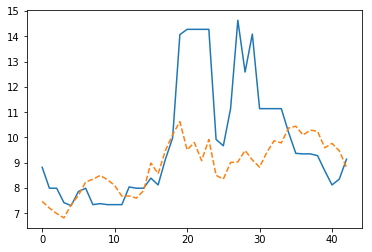

78 回目のループRandom Forest RMSE:  1.1829666652796238


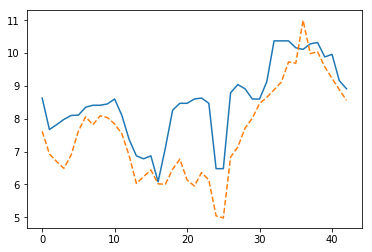

79 回目のループRandom Forest RMSE:  1.6775931049998842


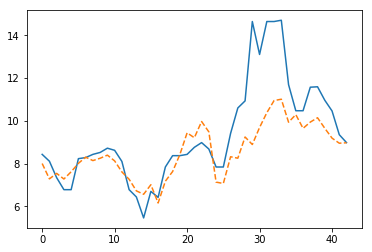

80 回目のループRandom Forest RMSE:  1.0708952034369135


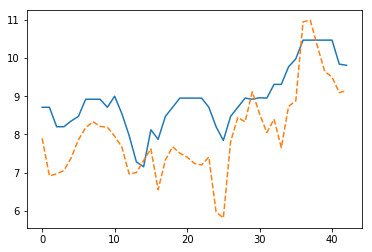

81 回目のループRandom Forest RMSE:  0.5667972311964738


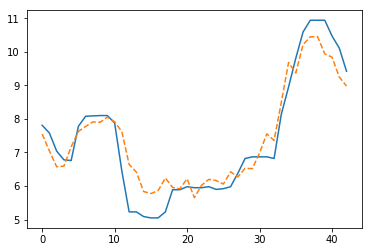

82 回目のループRandom Forest RMSE:  0.7541294795577087


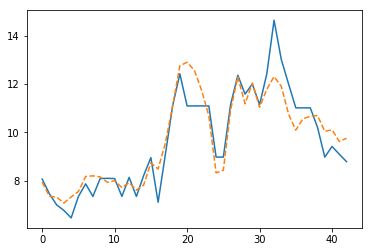

83 回目のループRandom Forest RMSE:  0.8391124952223278


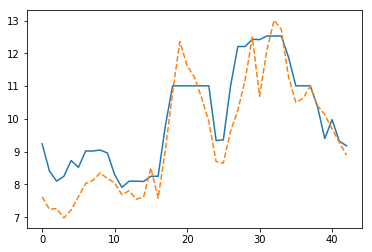

84 回目のループRandom Forest RMSE:  0.7484025140930344


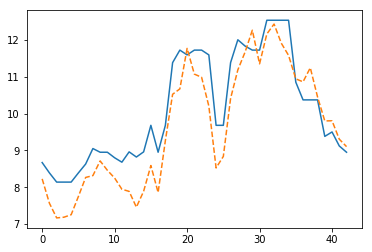

85 回目のループRandom Forest RMSE:  0.9096711935713027


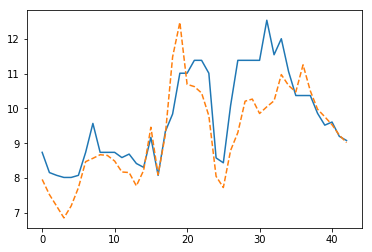

86 回目のループRandom Forest RMSE:  0.7575062458189893


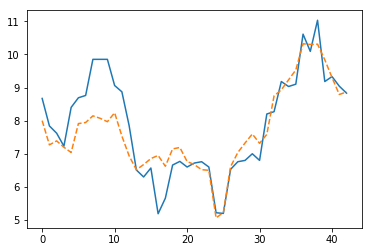

87 回目のループRandom Forest RMSE:  1.3581036835211817


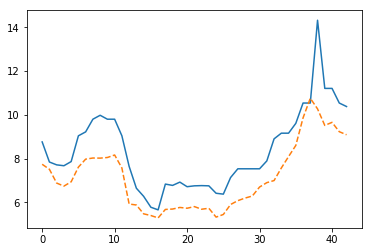

88 回目のループRandom Forest RMSE:  0.8455979443649397


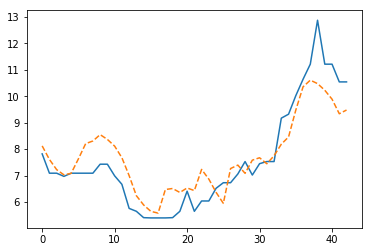

89 回目のループRandom Forest RMSE:  0.8579640749482503


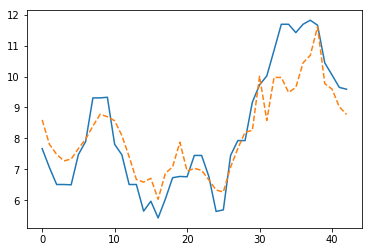

90 回目のループRandom Forest RMSE:  1.152547065544211


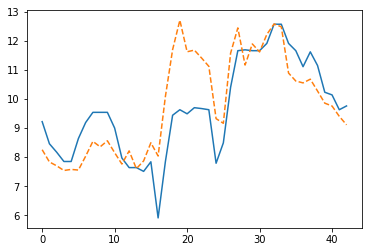

91 回目のループRandom Forest RMSE:  1.0889741450460664


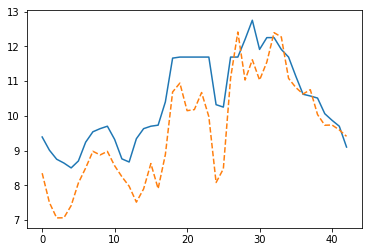

92 回目のループRandom Forest RMSE:  0.6925881013557301


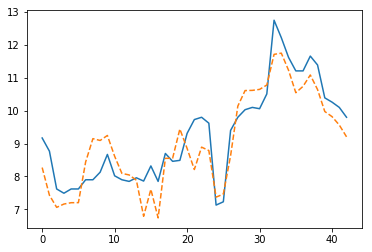

93 回目のループRandom Forest RMSE:  0.9620634436793056


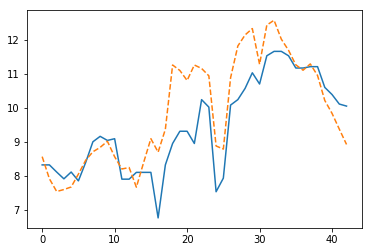

94 回目のループRandom Forest RMSE:  1.1528964974576554


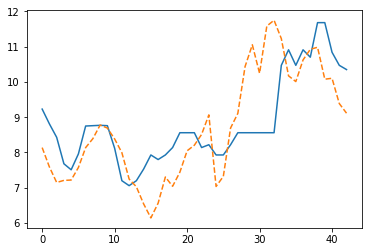

95 回目のループRandom Forest RMSE:  1.788900057785283


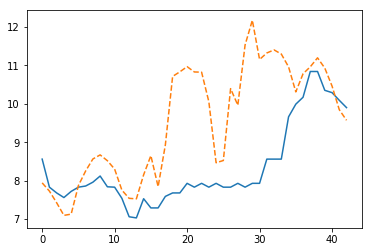

96 回目のループRandom Forest RMSE:  0.5782666258246583


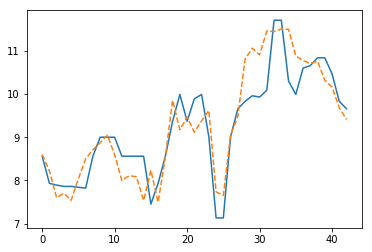

97 回目のループRandom Forest RMSE:  0.9894511144081952


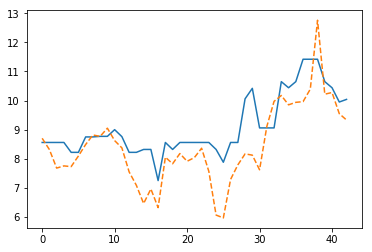

98 回目のループRandom Forest RMSE:  0.8722969139862145


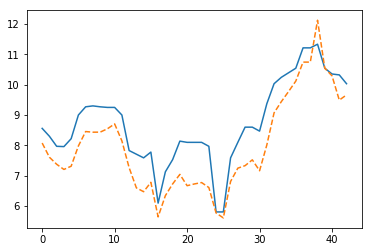

99 回目のループRandom Forest RMSE:  0.6419646462449671


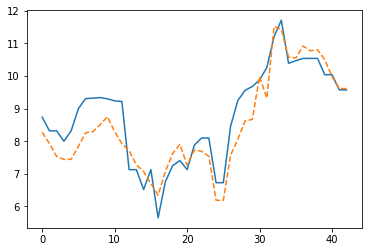

100 回目のループRandom Forest RMSE:  0.9567500772324183


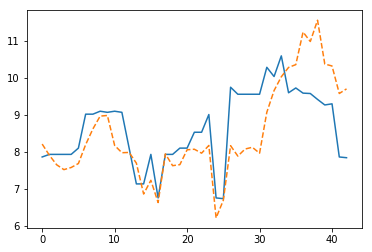

101 回目のループRandom Forest RMSE:  0.8789166745641324


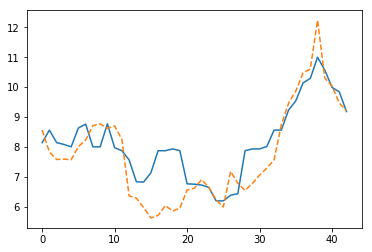

102 回目のループRandom Forest RMSE:  1.646305893975195


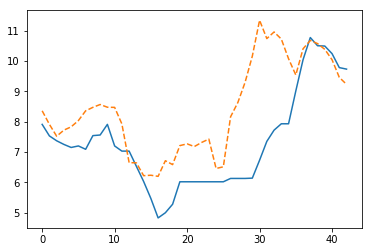

全体のRandom Forest RMSE:  1.3821878230178755


In [109]:
# "FCT_Dseries"と"targetprice_Dseries"を格納するBOXを定義
FCT_Dseries_BOX = []
targetprice_Dseries_BOX = []

##########################################################################################
### 日毎時系列プライスの予測vs実測を突き合わせて日毎のRMSEと予実グラフを描画するループ ###
##########################################################################################
for Dseries in range(FCT.shape[1]):
# 行列FCTのタテ↓方向(日毎時系列43コマ)データ"FCT_Dseries"集まれ
    FCT_Dseries = FCT[:,Dseries]
    FCT_Dseries_BOX.append(FCT_Dseries)
# 行列targetpriceのヨコ→方向(日毎時系列43コマ)データのtrainDAYs翌日から集まったデータ"targetprice_Dseries"
    targetprice_Dseries = targetprice[trainDAYs + Dseries]
    targetprice_Dseries_BOX.append(targetprice_Dseries)
# 日毎RMSEを計算
    rf_mse = mean_squared_error(targetprice_Dseries, FCT_Dseries)
    RMSE = np.sqrt(rf_mse)
    print(Dseries, "回目のループRandom Forest RMSE: ", RMSE)
# FCT_Dseries(予測プライス)とtargetprice_Dseries(実績プライス)をグラフで確認
    plt.plot(targetprice_Dseries)
    plt.plot(FCT_Dseries, linestyle = "dashed")
    plt.show()
    
# FCT_Dseries全部とtargetprice_Dseries全部で全体のRMSEを計算
rf_mse = mean_squared_error(targetprice_Dseries_BOX, FCT_Dseries_BOX)
RMSE = np.sqrt(rf_mse)
print("全体のRandom Forest RMSE: ", RMSE)

0.0 コマのRandom Forest RMSE:  0.8253359461141991


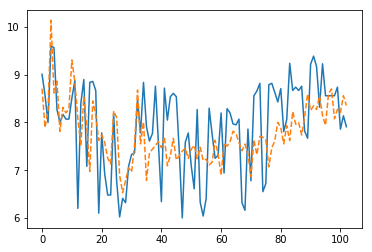

0.5 コマのRandom Forest RMSE:  0.7981398111512503


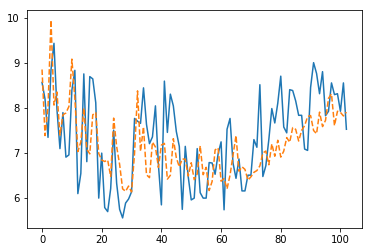

1.0 コマのRandom Forest RMSE:  0.8565374094872514


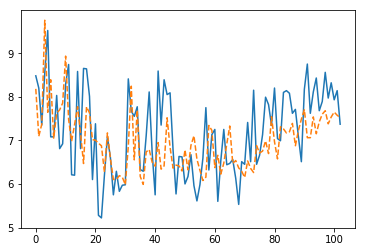

1.5 コマのRandom Forest RMSE:  0.8580519172188448


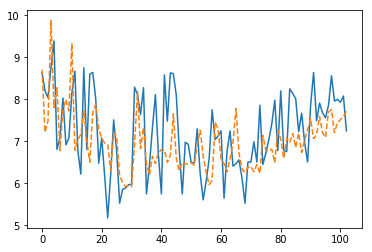

2.0 コマのRandom Forest RMSE:  0.8792904185115976


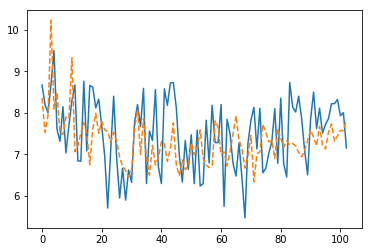

2.5 コマのRandom Forest RMSE:  0.7532670629556053


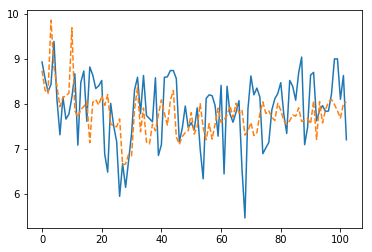

3.0 コマのRandom Forest RMSE:  0.7505411892232198


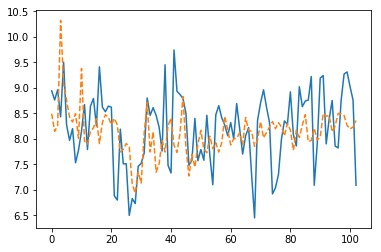

3.5 コマのRandom Forest RMSE:  0.8091616063553488


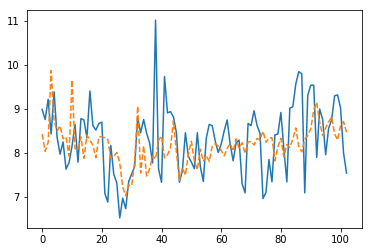

4.0 コマのRandom Forest RMSE:  0.9297340180360302


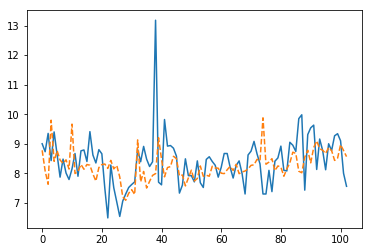

4.5 コマのRandom Forest RMSE:  0.9017791450521113


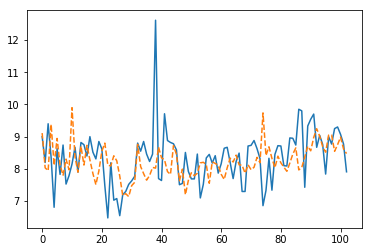

5.0 コマのRandom Forest RMSE:  0.8228627722026459


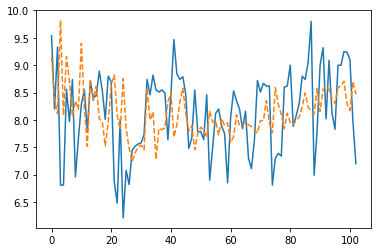

5.5 コマのRandom Forest RMSE:  0.8005575577015666


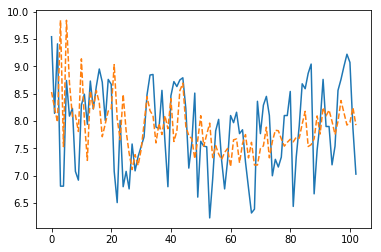

6.0 コマのRandom Forest RMSE:  0.8453146978895952


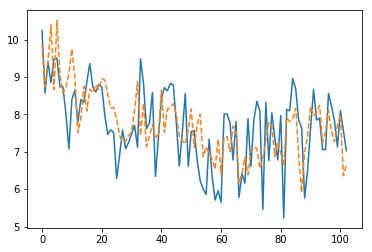

6.5 コマのRandom Forest RMSE:  1.0227904170009392


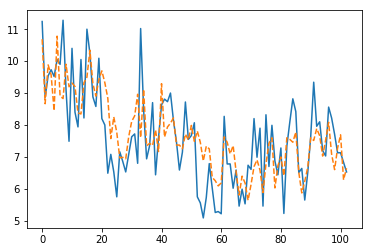

7.0 コマのRandom Forest RMSE:  1.1167262868303718


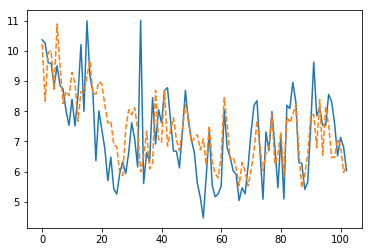

7.5 コマのRandom Forest RMSE:  1.4874060937062175


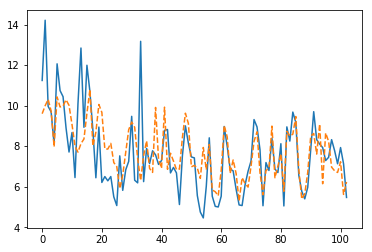

8.0 コマのRandom Forest RMSE:  1.410910322663218


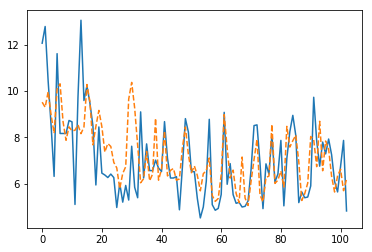

8.5 コマのRandom Forest RMSE:  1.9224401310398664


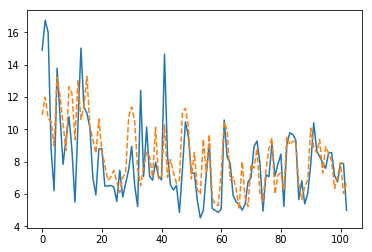

9.0 コマのRandom Forest RMSE:  2.1680783645083976


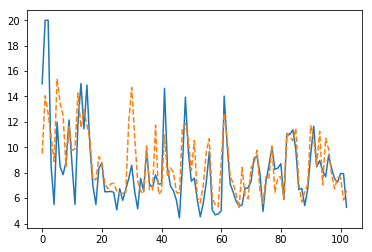

9.5 コマのRandom Forest RMSE:  2.2622971653945734


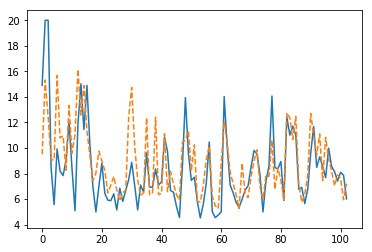

10.0 コマのRandom Forest RMSE:  1.8255437384673014


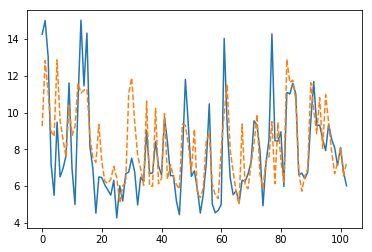

10.5 コマのRandom Forest RMSE:  1.6666799945745412


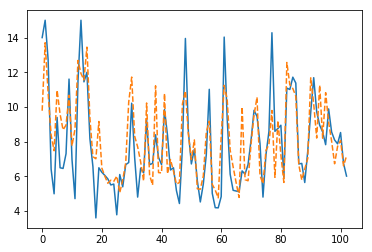

11.0 コマのRandom Forest RMSE:  1.794438855583923


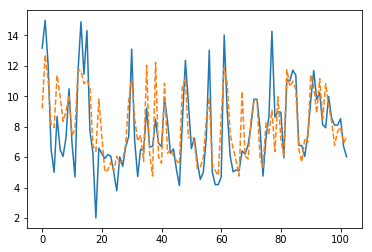

11.5 コマのRandom Forest RMSE:  1.7785305394578548


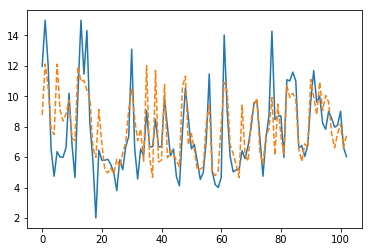

12.0 コマのRandom Forest RMSE:  1.178969571831811


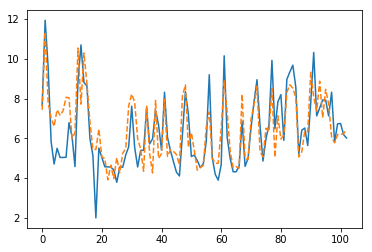

12.5 コマのRandom Forest RMSE:  1.1094422239701975


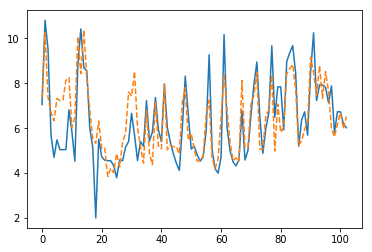

13.0 コマのRandom Forest RMSE:  1.7005145159586192


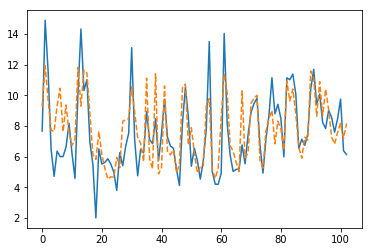

13.5 コマのRandom Forest RMSE:  1.8521047700449609


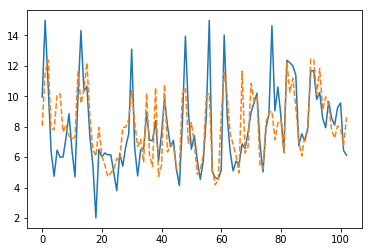

14.0 コマのRandom Forest RMSE:  1.8656406249219657


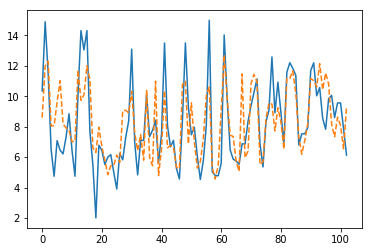

14.5 コマのRandom Forest RMSE:  1.9066538651775642


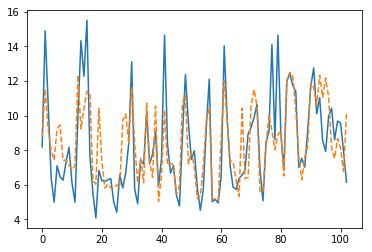

15.0 コマのRandom Forest RMSE:  1.5358436056493583


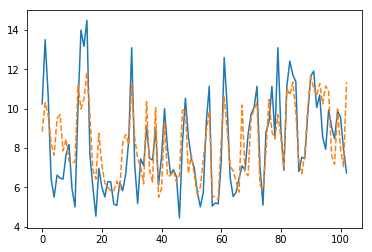

15.5 コマのRandom Forest RMSE:  1.7199565636747127


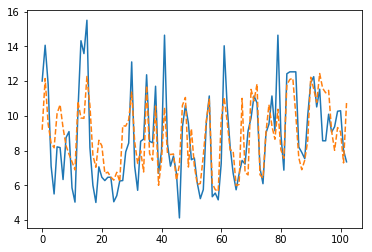

16.0 コマのRandom Forest RMSE:  1.721002801196442


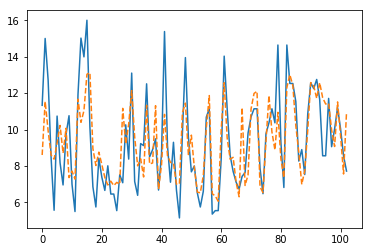

16.5 コマのRandom Forest RMSE:  1.7686073792816832


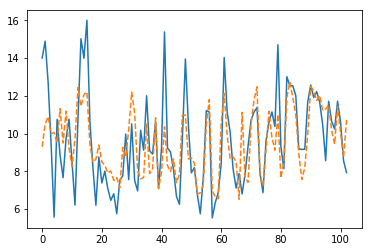

17.0 コマのRandom Forest RMSE:  1.6206817811161631


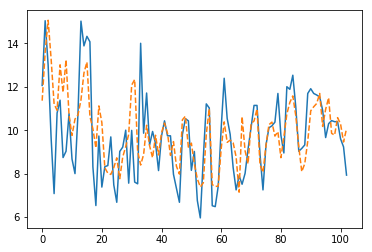

17.5 コマのRandom Forest RMSE:  1.3702283271964442


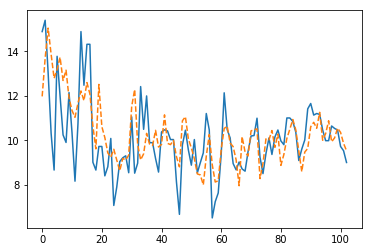

18.0 コマのRandom Forest RMSE:  1.4852944589162003


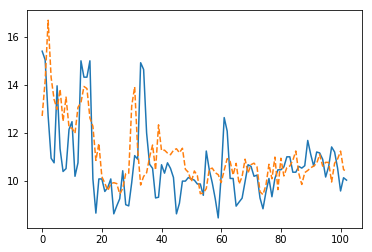

18.5 コマのRandom Forest RMSE:  1.3524236143069444


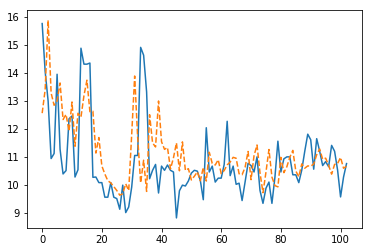

19.0 コマのRandom Forest RMSE:  1.1578109741517542


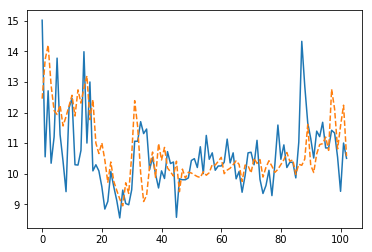

19.5 コマのRandom Forest RMSE:  1.049192873757271


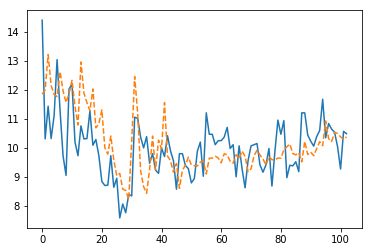

20.0 コマのRandom Forest RMSE:  0.9890643186622965


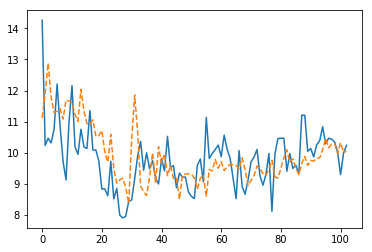

20.5 コマのRandom Forest RMSE:  0.8107790144482576


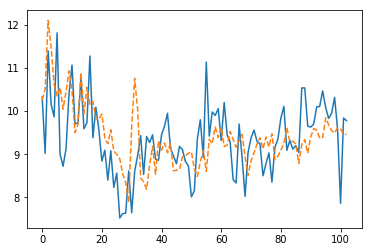

21.0 コマのRandom Forest RMSE:  0.7113803385409022


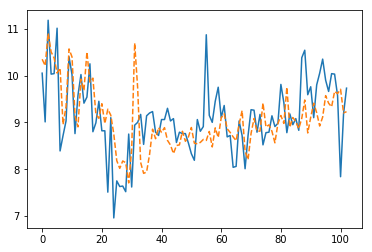

In [110]:
# "FCT_Tseries"と"targetprice_Tseries"を格納するBOXを定義
FCT_Tseries_BOX = []
targetprice_Tseries_BOX = []
RMSE_Tseries_BOX = []#Excelグラフ用

##############################################################################################
### コマ毎日系列プライスの予測vs実績を突き合わせてコマ毎のRMSEと予実グラフを描画するループ ###
##############################################################################################
for Tseries in range(len(TcomaTcode21)):
# 行列FCTのヨコ→方向(コマ毎日系列)データ"FCT_Tseries"集まれ
    FCT_Tseries = FCT[Tseries,:]
    FCT_Tseries_BOX.append(FCT_Tseries)
# 行列targetpriceのタテ↓方向(日毎時系列43コマ)データのtrainDAYs翌日から集まったデータ"targetprice_Tseries"
    targetprice_Tseries = targetprice[trainDAYs:, Tseries]
    targetprice_Tseries_BOX.append(targetprice_Tseries)
# コマ毎RMSEを計算
    lm_mse = mean_squared_error(targetprice_Tseries, FCT_Tseries)
    RMSE = np.sqrt(lm_mse)
    RMSE_Tseries_BOX.append(RMSE)
    print(Tseries/2, "コマのRandom Forest RMSE: ", RMSE)
# FCT_Tseries(予測プライス)とtargetprice_Tseries(実績プライス)をグラフで確認
    plt.plot(targetprice_Tseries)
    plt.plot(FCT_Tseries, linestyle = "dashed")
    plt.show()

In [26]:
np.savetxt("4th_RF_RMSE.csv", RMSE_Tseries_BOX, delimiter=",")